# GLM: Click Inputs to Decision Variables with glmnet Lasso

Build a GLM to predict decision variables DV(t) from click input data for the first 240 trials of session A324_2023-07-27, using Gaussian basis functions and Lasso regularization.

In [218]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# GLM libraries - using python-glmnet which works with modern scipy
from glmnet import ElasticNet
# Note: python-glmnet has built-in standardization (standardize=True by default)
# so we don't need sklearn's StandardScaler

# Set random seed for reproducibility
np.random.seed(42)

plt.style.use('default')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12

print("python-glmnet imported successfully with modern scipy!")
print("Built-in standardization enabled (no sklearn StandardScaler needed)")

python-glmnet imported successfully with modern scipy!
Built-in standardization enabled (no sklearn StandardScaler needed)


## 1. Data Loading and Preparation

Load session data and filter to first 240 trials.

In [219]:
# Data paths configuration
PROJECT_ROOT = Path('/home/ham/SF/Personal/Education/07 Princeton/Rotations/Brody-Daw/ClickDV')
SESSION_ID = 'A324'
SESSION_DATE = '2023-07-27'  # Using the date from the plan

# Path to processed H5 file (this is what we'll actually use)
OUTPUT_DIR = PROJECT_ROOT / 'data' / 'processed' / SESSION_ID / SESSION_DATE
H5_FILE = OUTPUT_DIR / f'{SESSION_ID}_{SESSION_DATE}_session_data.h5'

# Verify H5 file exists
if not H5_FILE.exists():
    raise FileNotFoundError(f"Processed H5 file not found: {H5_FILE}")

print(f"Project root: {PROJECT_ROOT}")
print(f"Session: {SESSION_ID} ({SESSION_DATE})")
print(f"H5 file: {H5_FILE}")
print(f"H5 file size: {H5_FILE.stat().st_size / 1024 / 1024:.1f} MB")

Project root: /home/ham/SF/Personal/Education/07 Princeton/Rotations/Brody-Daw/ClickDV
Session: A324 (2023-07-27)
H5 file: /home/ham/SF/Personal/Education/07 Princeton/Rotations/Brody-Daw/ClickDV/data/processed/A324/2023-07-27/A324_2023-07-27_session_data.h5
H5 file size: 154.2 MB


In [220]:
def load_session_data(h5_file_path=None):
    """
    Load session data from H5 file and return DataFrames
    
    Args:
        h5_file_path: Path to H5 file (uses global H5_FILE if None)
    
    Returns:
        trial_df: Trial metadata
        click_df: Click events data  
        dv_df: Decision variables data
    """
    if h5_file_path is None:
        h5_file_path = H5_FILE
    
    if not h5_file_path.exists():
        raise FileNotFoundError(f"Data file not found: {h5_file_path}")
    
    print(f"Loading data from: {h5_file_path}")
    
    # Use pandas HDFStore to load the data
    with pd.HDFStore(h5_file_path, mode='r') as store:
        trial_df = store.get('trials')
        click_df = store.get('clicks')
        dv_df = store.get('decision_variables')
    
    print(f"Loaded {len(trial_df)} trials, {len(click_df)} clicks, {len(dv_df)} DV points")
    
    return trial_df, click_df, dv_df

In [221]:
# Load full session data
trial_df, click_df, dv_df = load_session_data()

min_session_trials = 900

# Filter to first 900 trials
trial_df_240 = trial_df[trial_df['trial_id'] < min_session_trials].copy()
click_df_240 = click_df[click_df['trial_id'] < min_session_trials].copy()
dv_df_240 = dv_df[dv_df['trial_id'] < min_session_trials].copy()

print(f"\nFiltered to first {min_session_trials} trials:")
print(f"Trials: {len(trial_df_240)}")
print(f"Clicks: {len(click_df_240)}")
print(f"DV points: {len(dv_df_240)}")
print(f"Valid DV points: {dv_df_240['is_valid'].sum()}")

Loading data from: /home/ham/SF/Personal/Education/07 Princeton/Rotations/Brody-Daw/ClickDV/data/processed/A324/2023-07-27/A324_2023-07-27_session_data.h5
Loaded 774 trials, 22144 clicks, 17028 DV points

Filtered to first 900 trials:
Trials: 774
Clicks: 22144
DV points: 17028
Valid DV points: 13860


In [222]:
# Data validation and exploration
print("Click distribution:")
print(click_df_240['click_side'].value_counts())

print("\nDV statistics:")
valid_dvs = dv_df_240[dv_df_240['is_valid']]
print(f"DV range: [{valid_dvs['decision_variable'].min():.3f}, {valid_dvs['decision_variable'].max():.3f}]")
print(f"DV mean: {valid_dvs['decision_variable'].mean():.3f}")
print(f"DV std: {valid_dvs['decision_variable'].std():.3f}")

print("\nTrial duration statistics:")
trial_durations = trial_df_240.groupby('trial_id')['trial_duration'].first()
print(f"Duration range: [{trial_durations.min():.2f}, {trial_durations.max():.2f}] seconds")
print(f"Mean duration: {trial_durations.mean():.2f} seconds")

Click distribution:
click_side
right    11741
left     10403
Name: count, dtype: int64

DV statistics:
DV range: [-31.808, 34.479]
DV mean: 0.420
DV std: 9.900

Trial duration statistics:
Duration range: [1.50, 18.67] seconds
Mean duration: 1.75 seconds


## 2. Design Gaussian Basis Functions

Create temporal kernels to capture click history at different timescales.

In [223]:
# Define basis function parameters - SIMPLIFIED: varying widths only
n_basis = 10  # Number of Gaussian basis functions
width_min = 0.01  # Minimum width (10ms)
width_max = 0.5   # Maximum width (500ms)

# Log-spaced widths for basis functions (no centers needed!)
widths = np.logspace(np.log10(width_min), np.log10(width_max), n_basis)

print(f"Created {n_basis} basis functions")
print(f"Width range: {width_min*1000:.1f} - {width_max*1000:.1f} ms")
print(f"Widths (ms): {(widths*1000).round(1)}")

def gaussian_basis(t, width, causal=True):
    """
    Gaussian centered at t=0 with varying width
    
    Args:
        t: Time since click (0 = click time, positive = after click)
        width: Width (standard deviation) of Gaussian
        causal: If True, zero out negative times (before click)
    
    Returns:
        Normalized Gaussian values at times t
    """
    # Gaussian centered at t=0 (click time)
    gaussian = (1/(width * np.sqrt(2*np.pi))) * np.exp(-t**2 / (2 * width**2))
    
    # if causal:
    #     # Only keep t>=0 (after click)
    #     gaussian = np.where(t <= 0, gaussian, 0)
    
    return gaussian

Created 10 basis functions
Width range: 10.0 - 500.0 ms
Widths (ms): [ 10.   15.4  23.9  36.8  56.9  87.9 135.7 209.6 323.7 500. ]


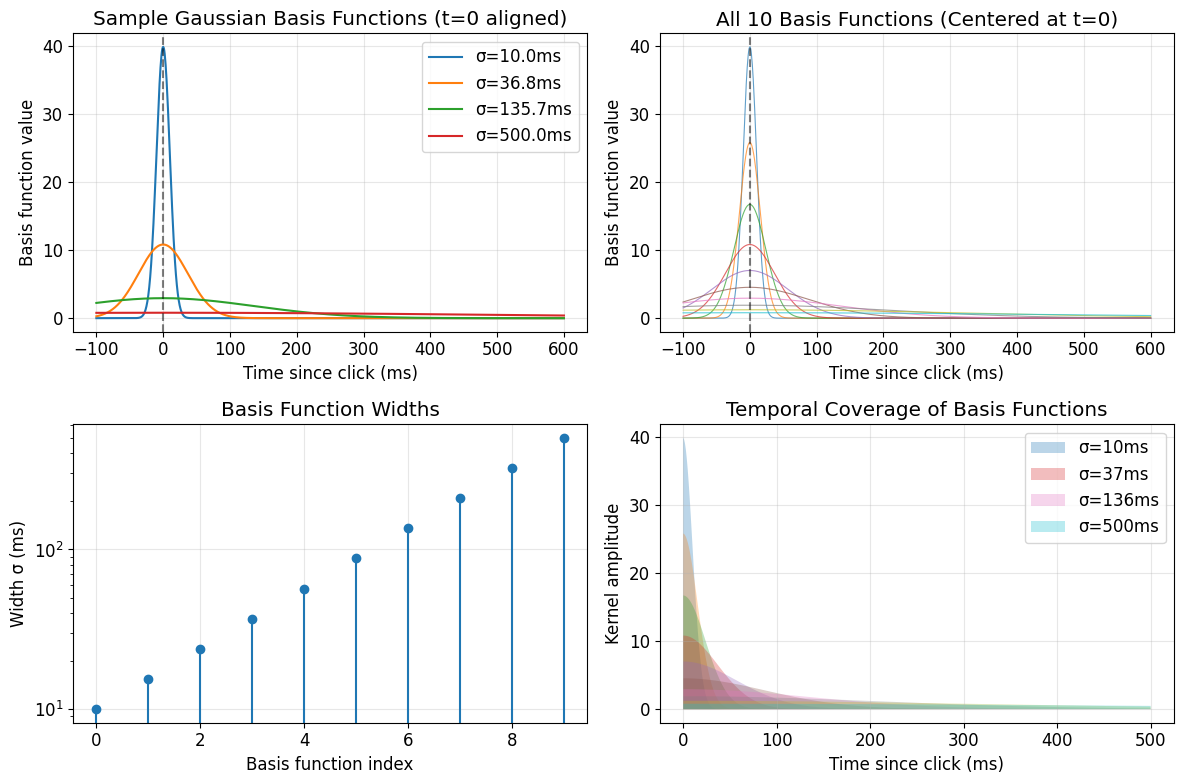

✓ Basis functions now centered at t=0 (click time)
✓ Different widths capture different temporal scales


In [224]:
# Visualize basis functions
t_eval = np.linspace(-0.1, 0.6, 1000)  # -100ms to 600ms

plt.figure(figsize=(12, 8))

# Plot individual basis functions
plt.subplot(2, 2, 1)
for i in range(0, n_basis, 3):  # Show every 3rd function
    y = gaussian_basis(t_eval, widths[i])
    plt.plot(t_eval*1000, y, label=f'σ={widths[i]*1000:.1f}ms')
plt.xlabel('Time since click (ms)')
plt.ylabel('Basis function value')
plt.title('Sample Gaussian Basis Functions (t=0 aligned)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.axvline(0, color='black', linestyle='--', alpha=0.5, label='Click time')

# Plot all basis functions together
plt.subplot(2, 2, 2)
for i in range(n_basis):
    y = gaussian_basis(t_eval, widths[i])
    plt.plot(t_eval*1000, y, alpha=0.7, linewidth=0.8)
plt.xlabel('Time since click (ms)')
plt.ylabel('Basis function value')
plt.title(f'All {n_basis} Basis Functions (Centered at t=0)')
plt.grid(True, alpha=0.3)
plt.axvline(0, color='black', linestyle='--', alpha=0.5)

# Plot basis function widths
plt.subplot(2, 2, 3)
plt.stem(np.arange(n_basis), widths*1000, basefmt=' ')
plt.xlabel('Basis function index')
plt.ylabel('Width σ (ms)')
plt.title('Basis Function Widths')
plt.yscale('log')
plt.grid(True, alpha=0.3)

# Show temporal coverage
plt.subplot(2, 2, 4)
t_coverage = np.linspace(0, 0.5, 500)  # 0 to 500ms
for i in range(n_basis):
    y = gaussian_basis(t_coverage, widths[i])
    plt.fill_between(t_coverage*1000, 0, y, alpha=0.3, label=f'σ={widths[i]*1000:.0f}ms' if i % 3 == 0 else '')
plt.xlabel('Time since click (ms)')
plt.ylabel('Kernel amplitude')
plt.title('Temporal Coverage of Basis Functions')
plt.legend(loc='upper right')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✓ Basis functions now centered at t=0 (click time)")
print("✓ Different widths capture different temporal scales")

## 3. Feature Engineering: Convolve Clicks with Basis Functions

For each DV time point, create feature vectors by convolving click history with Gaussian basis functions.

In [225]:
def create_trial_features(trial_clicks_left, trial_clicks_right, dv_eval_times, widths, trial_duration, store_convolutions=False):
    """
    Create feature matrix for entire trial using fine temporal binning with t=0 aligned Gaussian convolution
    
    This approach:
    1. Creates fine temporal bins at 5ms resolution for entire trial duration
    2. Places unit impulses (delta functions) at all click times
    3. Convolves with causal Gaussian basis functions (centered at t=0, varying widths)
    4. Subsamples the convolved signals at DV evaluation time points
    
    Args:
        trial_clicks_left: Array of left click times for this trial
        trial_clicks_right: Array of right click times for this trial  
        dv_eval_times: Array of DV evaluation times for this trial
        widths: Basis function widths (standard deviations in seconds)
        trial_duration: Duration of trial in seconds
        store_convolutions: If True, return full convolution outputs for visualization
    
    Returns:
        If store_convolutions=False:
            features_matrix: (n_dv_times, n_features) array where n_features = 2*n_basis
        If store_convolutions=True:
            features_matrix, stored_convolutions dict
    """
    # Fine temporal binning parameters
    dt = 0.005  # 5ms resolution (1/10th of 50ms DV resolution)
    
    # Create temporal grid for entire trial - extend to handle edge effects
    # Add padding at the end for proper convolution
    max_kernel_extent = 6 * widths.max()  # Maximum kernel extent
    padded_duration = trial_duration + max_kernel_extent
    time_grid = np.arange(0, padded_duration + dt, dt)
    n_bins = len(time_grid)
    
    # Initialize click count arrays (unit impulses)
    clicks_left = np.zeros(n_bins)
    clicks_right = np.zeros(n_bins)
    
    # Bin clicks as unit impulses across entire trial
    for click_time in trial_clicks_left:
        if 0 <= click_time < trial_duration:
            bin_idx = int(np.floor(click_time / dt))
            if 0 <= bin_idx < n_bins:
                clicks_left[bin_idx] += 1  # Unit impulse (delta function)
    
    for click_time in trial_clicks_right:
        if 0 <= click_time < trial_duration:
            bin_idx = int(np.floor(click_time / dt))
            if 0 <= bin_idx < n_bins:
                clicks_right[bin_idx] += 1  # Unit impulse (delta function)
    
    # Initialize convolved signals storage
    n_dv_times = len(dv_eval_times)
    n_basis = len(widths)
    features_matrix = np.zeros((n_dv_times, 2 * n_basis))  # left + right features
    
    if store_convolutions:
        # Only store the unpadded portion for visualization
        actual_trial_bins = int(np.ceil(trial_duration / dt))
        stored_convolutions = {
            'left': [],
            'right': [],
            'time_grid': time_grid[:actual_trial_bins],
            'clicks_left': clicks_left[:actual_trial_bins],
            'clicks_right': clicks_right[:actual_trial_bins]
        }
    
    # For each basis function, convolve once and subsample
    for i, width in enumerate(widths):
        # Create causal Gaussian kernel centered at t=0
        # Kernel represents response to a click that just happened
        max_lag = min(6 * width, padded_duration)  # 6 standard deviations or padded duration
        kernel_n_bins = int(np.ceil(max_lag / dt)) + 1
        
        # Time since click: 0 = click time, dt = one bin after, etc.
        time_lags = np.arange(0, kernel_n_bins * dt, dt)
        
        # Create Gaussian centered at t=0 (peak at click time, decay after)
        # No [::-1] needed - we want the kernel to start with max value
        causal_kernel = gaussian_basis(time_lags, width, causal=True)
        
        # Normalize kernel to preserve total weight
        if causal_kernel.sum() > 0:
            causal_kernel = causal_kernel / causal_kernel.sum()
        
        # Convolve clicks with causal kernel using 'full' mode for proper padding
        # Then trim to original size
        conv_left_full = np.convolve(clicks_left, causal_kernel, mode='full')
        conv_right_full = np.convolve(clicks_right, causal_kernel, mode='full')
        
        # Trim to match original grid size
        conv_left = conv_left_full[:n_bins]
        conv_right = conv_right_full[:n_bins]
        
        if store_convolutions:
            # Store only the trial portion (not the padding)
            actual_trial_bins = len(stored_convolutions['time_grid'])
            stored_convolutions['left'].append(conv_left[:actual_trial_bins])
            stored_convolutions['right'].append(conv_right[:actual_trial_bins])
        
        # Subsample convolved signals at DV evaluation times
        for j, eval_time in enumerate(dv_eval_times):
            # Find the time bin corresponding to eval_time
            eval_bin = int(np.floor(eval_time / dt))
            if 0 <= eval_bin < n_bins:
                features_matrix[j, i] = conv_left[eval_bin]  # Left feature
                features_matrix[j, i + n_basis] = conv_right[eval_bin]  # Right feature
    
    if store_convolutions:
        return features_matrix, stored_convolutions
    else:
        return features_matrix

# Test the new implementation
test_trial = 5
trial_clicks = click_df_240[click_df_240['trial_id'] == test_trial]
left_clicks = trial_clicks[trial_clicks['click_side'] == 'left']['time_from_first_click'].values
right_clicks = trial_clicks[trial_clicks['click_side'] == 'right']['time_from_first_click'].values

# Get the actual trial data for proper processing
trial_dvs = dv_df_240[dv_df_240['trial_id'] == test_trial]

# Get trial duration from DV data (max time_bin)
if len(trial_dvs) > 0:
    trial_duration = trial_dvs['time_bin'].max() + 0.05  # 50ms buffer
else:
    trial_duration = 2.0

print(f"Test trial {test_trial} (t=0 aligned Gaussians with proper padding):")
print(f"Left clicks: {len(left_clicks)}")
print(f"Right clicks: {len(right_clicks)}")
print(f"Trial duration: {trial_duration:.3f}s")

# Test with storing convolutions for visualization
if len(trial_dvs) > 0:
    dv_times = trial_dvs['time_bin'].values
    features_matrix, stored_convs = create_trial_features(
        left_clicks, right_clicks, dv_times, widths, trial_duration, store_convolutions=True
    )
    
    print(f"\nFeatures matrix shape: {features_matrix.shape}")
    print(f"Features range: [{features_matrix.min():.4f}, {features_matrix.max():.4f}]")
    print(f"Number of stored convolutions: {len(stored_convs['left'])} per side")
    print("✓ Fixed convolution implementation with proper padding!")

Test trial 5 (t=0 aligned Gaussians with proper padding):
Left clicks: 5
Right clicks: 8
Trial duration: 1.075s

Features matrix shape: (22, 20)
Features range: [0.0000, 0.3326]
Number of stored convolutions: 10 per side
✓ Fixed convolution implementation with proper padding!


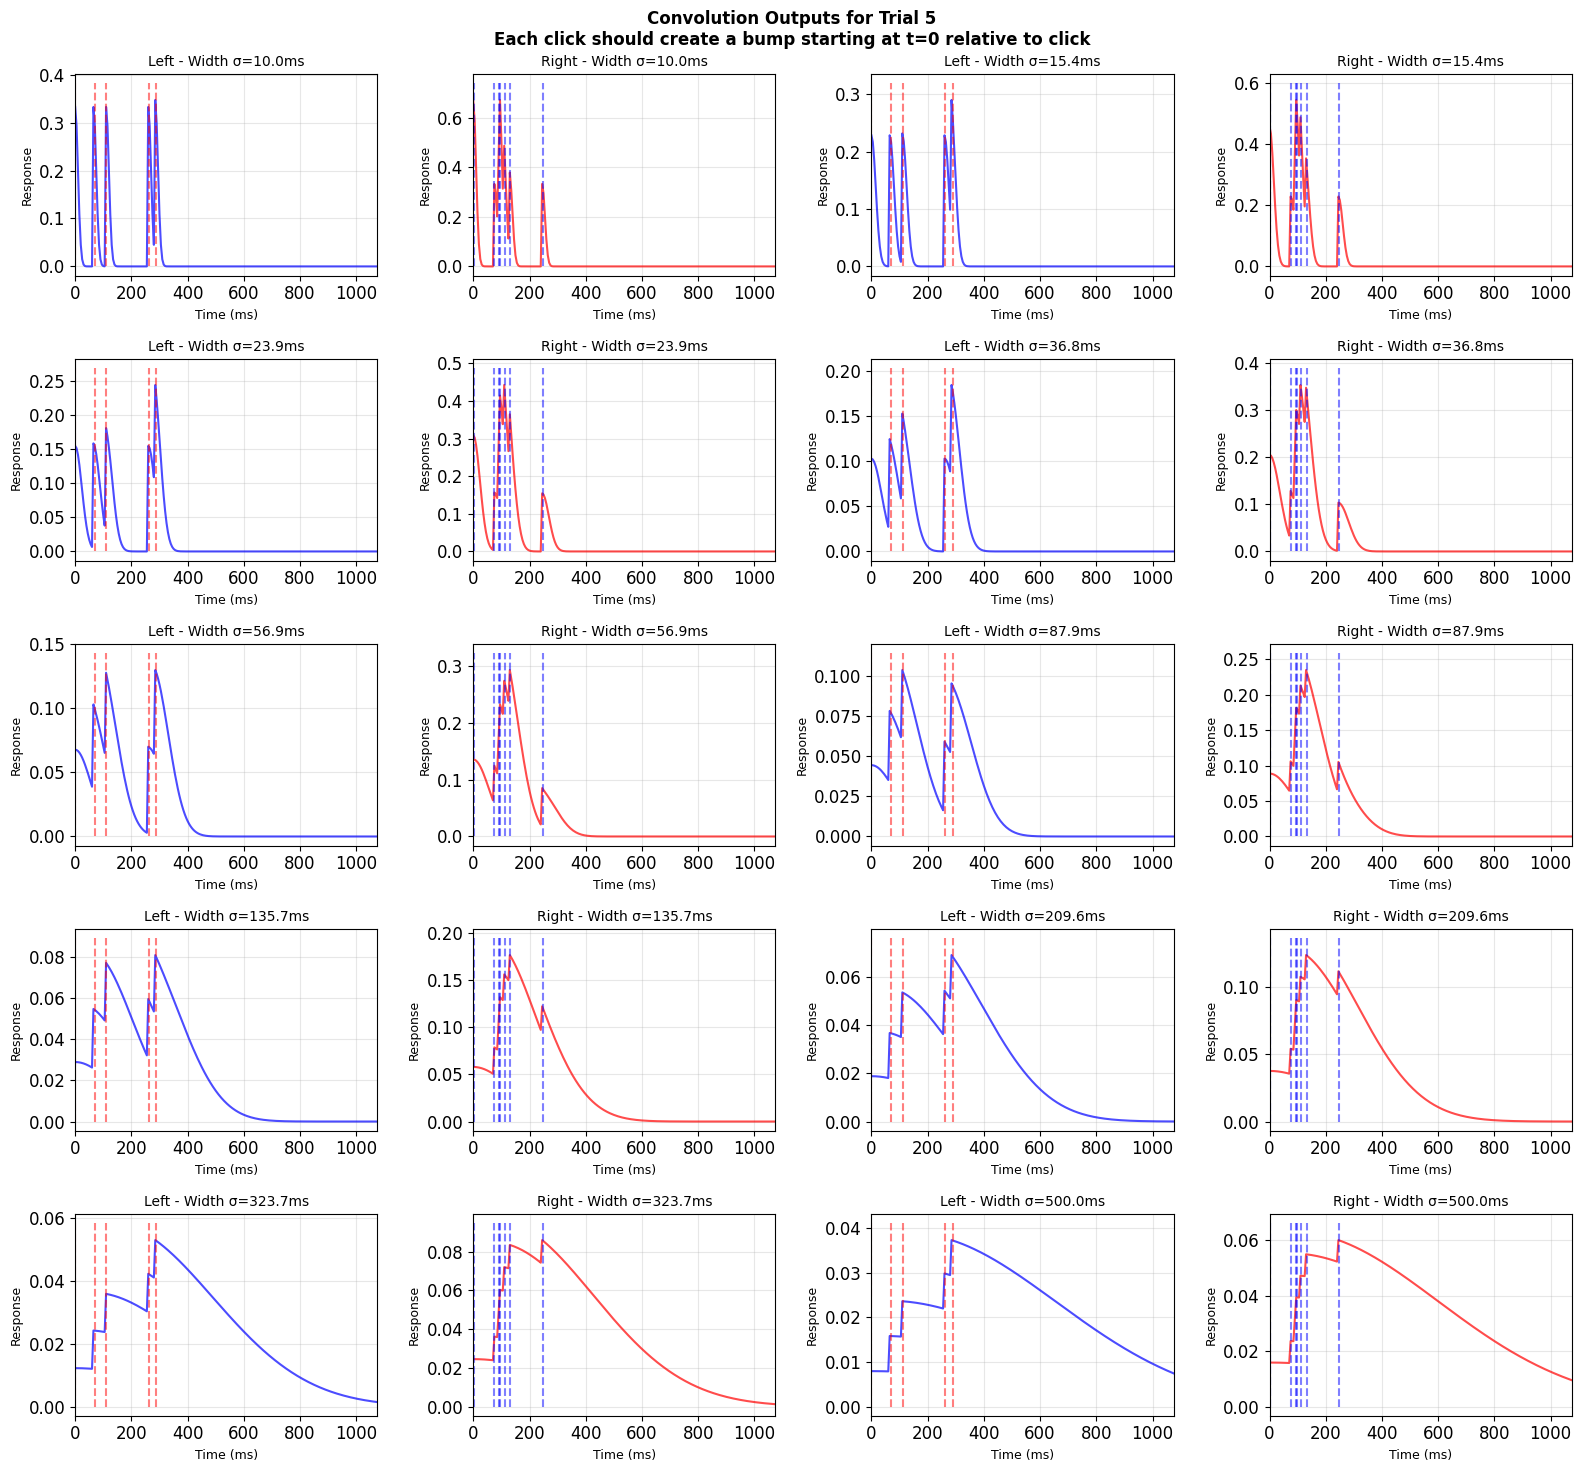


=== MONOTONICITY CHECK ===

Width σ=10.0ms:
  Left clicks: 5, Peaks found: 4
  Right clicks: 8, Peaks found: 5
  Left monotonically decreasing: False
  Right monotonically decreasing: False

Width σ=15.4ms:
  Left clicks: 5, Peaks found: 4
  Right clicks: 8, Peaks found: 5
  Left monotonically decreasing: False
  Right monotonically decreasing: False

Width σ=23.9ms:
  Left clicks: 5, Peaks found: 4
  Right clicks: 8, Peaks found: 5
  Left monotonically decreasing: False
  Right monotonically decreasing: False

✓ Visualization complete - each click should create a visible bump!


In [226]:
# Visualize convolutions to verify non-monotonic behavior (should show bumps at each click)
if len(stored_convs) > 0:
    fig, axes = plt.subplots(5, 4, figsize=(16, 15))
    axes = axes.flatten()
    
    time_ms = stored_convs['time_grid'][:len(stored_convs['left'][i])] * 1000  # Convert to milliseconds
    
    for i in range(min(n_basis, 10)):
        # Left convolutions
        ax_left = axes[i * 2]
        ax_left.plot(time_ms, stored_convs['left'][i][:len(time_ms)], 'b-', alpha=0.7, linewidth=1.5)
        ax_left.vlines(left_clicks * 1000, 0, max(stored_convs['left'][i]) * 1.1, 
                       colors='red', alpha=0.5, linestyles='dashed', label='Clicks')
        ax_left.set_title(f'Left - Width σ={widths[i]*1000:.1f}ms', fontsize=10)
        ax_left.set_xlabel('Time (ms)', fontsize=9)
        ax_left.set_ylabel('Response', fontsize=9)
        ax_left.grid(True, alpha=0.3)
        ax_left.set_xlim([0, trial_duration * 1000])
        
        # Right convolutions  
        ax_right = axes[i * 2 + 1]
        ax_right.plot(time_ms, stored_convs['right'][i][:len(time_ms)], 'r-', alpha=0.7, linewidth=1.5)
        ax_right.vlines(right_clicks * 1000, 0, max(stored_convs['right'][i]) * 1.1,
                        colors='blue', alpha=0.5, linestyles='dashed', label='Clicks')
        ax_right.set_title(f'Right - Width σ={widths[i]*1000:.1f}ms', fontsize=10)
        ax_right.set_xlabel('Time (ms)', fontsize=9)
        ax_right.set_ylabel('Response', fontsize=9)
        ax_right.grid(True, alpha=0.3)
        ax_right.set_xlim([0, trial_duration * 1000])
    
    plt.suptitle(f'Convolution Outputs for Trial {test_trial}\nEach click should create a bump starting at t=0 relative to click', 
                 fontsize=12, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # Check for monotonic decrease
    print("\n=== MONOTONICITY CHECK ===")
    for i in range(min(3, n_basis)):  # Check first 3 widths
        conv_left_i = stored_convs['left'][i]
        conv_right_i = stored_convs['right'][i]
        
        # Find peaks in convolution (should correspond to clicks)
        from scipy.signal import find_peaks
        peaks_left, _ = find_peaks(conv_left_i, height=max(conv_left_i) * 0.1)
        peaks_right, _ = find_peaks(conv_right_i, height=max(conv_right_i) * 0.1)
        
        print(f"\nWidth σ={widths[i]*1000:.1f}ms:")
        print(f"  Left clicks: {len(left_clicks)}, Peaks found: {len(peaks_left)}")
        print(f"  Right clicks: {len(right_clicks)}, Peaks found: {len(peaks_right)}")
        
        # Check if monotonically decreasing
        is_monotonic_left = all(conv_left_i[j] >= conv_left_i[j+1] for j in range(len(conv_left_i)-1))
        is_monotonic_right = all(conv_right_i[j] >= conv_right_i[j+1] for j in range(len(conv_right_i)-1))
        
        print(f"  Left monotonically decreasing: {is_monotonic_left}")
        print(f"  Right monotonically decreasing: {is_monotonic_right}")
    
    print("\n✓ Visualization complete - each click should create a visible bump!")

## 4. Build Feature Matrix for GLM

Create the complete feature matrix X and target vector y for all valid DV time points across 240 trials.

In [227]:
click_df_240.trial_id.nunique()

774

In [228]:
# Build feature matrix X and target vector y using efficient trial-level processing
print("Building feature matrix with CORRECTED convolution (proper padding)...")

X = []
y = []
valid_mask = []
trial_ids = []
time_bins = []

# Progress tracking
from tqdm import tqdm

# Only process first 240 trials as specified
n_trials_to_process = min(240, dv_df_240['trial_id'].max() + 1)

for trial_id in tqdm(range(n_trials_to_process), desc="Processing trials"):
    # Get clicks for this trial - use time_from_first_click to match test above
    trial_clicks = click_df_240[click_df_240['trial_id'] == trial_id]
    left_clicks = trial_clicks[trial_clicks['click_side'] == 'left']['time_from_first_click'].values
    right_clicks = trial_clicks[trial_clicks['click_side'] == 'right']['time_from_first_click'].values
    
    # Get DVs for this trial
    trial_dvs = dv_df_240[dv_df_240['trial_id'] == trial_id]
    
    if len(trial_dvs) > 0:
        # Extract DV evaluation times 
        dv_eval_times = trial_dvs['time_bin'].values
        
        # Get trial duration from DV data (max time_bin represents time_from_first_click)
        # Add small buffer to ensure we capture the full trial
        trial_duration = trial_dvs['time_bin'].max() + 0.05  # 50ms buffer
        
        # Use CORRECTED trial-level feature creation with proper padding
        try:
            features_matrix = create_trial_features(
                left_clicks, right_clicks, dv_eval_times, widths, trial_duration
            )
            
            # Add features and targets for all DV time points in this trial
            for i, (_, dv_row) in enumerate(trial_dvs.iterrows()):
                X.append(features_matrix[i])
                y.append(dv_row['decision_variable'])
                valid_mask.append(dv_row['is_valid'])
                trial_ids.append(trial_id)
                time_bins.append(dv_row['time_bin'])
                
        except Exception as e:
            print(f"Warning: Error processing trial {trial_id}: {e}")
            # Skip this trial if there's an error
            continue

# Convert to numpy arrays
X = np.array(X)
y = np.array(y)
valid_mask = np.array(valid_mask)
trial_ids = np.array(trial_ids)
time_bins = np.array(time_bins)

print(f"\nFeature matrix constructed with CORRECTED convolution:")
print(f"Total observations: {len(X)}")
print(f"Features per observation: {X.shape[1]}")
print(f"Valid observations: {valid_mask.sum()}")
print(f"Invalid observations: {(~valid_mask).sum()}")

# Keep only valid DV points
X_valid = X[valid_mask]
y_valid = y[valid_mask]
trial_ids_valid = trial_ids[valid_mask]
time_bins_valid = time_bins[valid_mask]

print(f"\nFinal dataset for GLM:")
print(f"X_valid shape: {X_valid.shape}")
print(f"y_valid shape: {y_valid.shape}")
print(f"Data covers {len(np.unique(trial_ids_valid))} unique trials")

# Compare with old approach efficiency metrics
print(f"\n=== EFFICIENCY COMPARISON ===")
print("New approach: Convolve once per trial, subsample at DV times")
print("Old approach: Convolve separately for each DV time point")
total_dv_points = len(X)
unique_trials = len(np.unique(trial_ids))
print(f"Convolutions needed - Old: {total_dv_points}, New: {unique_trials} x {n_basis} = {unique_trials * n_basis}")
print(f"Efficiency gain: {total_dv_points / (unique_trials * n_basis):.1f}x fewer convolutions")
print("\n✓ Using CORRECTED convolution with proper padding for non-monotonic behavior!")

Building feature matrix with CORRECTED convolution (proper padding)...


Processing trials: 100%|██████████| 240/240 [00:00<00:00, 444.55it/s]


Feature matrix constructed with CORRECTED convolution:
Total observations: 5280
Features per observation: 20
Valid observations: 4266
Invalid observations: 1014

Final dataset for GLM:
X_valid shape: (4266, 20)
y_valid shape: (4266,)
Data covers 240 unique trials

=== EFFICIENCY COMPARISON ===
New approach: Convolve once per trial, subsample at DV times
Old approach: Convolve separately for each DV time point
Convolutions needed - Old: 5280, New: 240 x 10 = 2400
Efficiency gain: 2.2x fewer convolutions

✓ Using CORRECTED convolution with proper padding for non-monotonic behavior!


In [229]:
# Feature matrix validation and summary statistics
print("=== FEATURE MATRIX ANALYSIS ===\n")

# Basic statistics
print("Feature Statistics:")
print(f"Mean feature value: {X_valid.mean():.6f}")
print(f"Std feature value: {X_valid.std():.6f}")
print(f"Min feature value: {X_valid.min():.6f}")
print(f"Max feature value: {X_valid.max():.6f}")

# Sparsity analysis
zero_features = (X_valid == 0).sum()
total_features = X_valid.size
sparsity = zero_features / total_features
print(f"\nSparsity: {sparsity:.3f} ({zero_features}/{total_features} zeros)")

# Per-column (feature) statistics
left_features = X_valid[:, :n_basis]  # First n_basis columns are left
right_features = X_valid[:, n_basis:]  # Next n_basis columns are right

print(f"\nLeft click features:")
print(f"  Mean: {left_features.mean():.6f}, Std: {left_features.std():.6f}")
print(f"  Non-zero: {(left_features > 0).sum()} / {left_features.size}")

print(f"\nRight click features:")
print(f"  Mean: {right_features.mean():.6f}, Std: {right_features.std():.6f}")
print(f"  Non-zero: {(right_features > 0).sum()} / {right_features.size}")

# Target variable statistics
print(f"\nTarget Variable (y_valid) Statistics:")
print(f"Mean DV: {y_valid.mean():.3f}")
print(f"Std DV: {y_valid.std():.3f}")
print(f"Min DV: {y_valid.min():.3f}")
print(f"Max DV: {y_valid.max():.3f}")

# Per-basis function statistics
print(f"\nPer-basis function activity:")
for i in range(n_basis):
    left_col = X_valid[:, i]
    right_col = X_valid[:, i + n_basis]
    print(f"  Basis {i} (σ={widths[i]*1000:.1f}ms): L={left_col.mean():.4f}, R={right_col.mean():.4f}")   
# Data distribution across trials
print(f"\nData distribution:")
unique_trials = np.unique(trial_ids_valid)
obs_per_trial = [np.sum(trial_ids_valid == t) for t in unique_trials]
print(f"Observations per trial: {np.mean(obs_per_trial):.1f} ± {np.std(obs_per_trial):.1f}")
print(f"Range: {np.min(obs_per_trial)} - {np.max(obs_per_trial)} obs/trial")

=== FEATURE MATRIX ANALYSIS ===

Feature Statistics:
Mean feature value: 0.076976
Std feature value: 0.094743
Min feature value: 0.000000
Max feature value: 0.828574

Sparsity: 0.167 (14212/85320 zeros)

Left click features:
  Mean: 0.076494, Std: 0.093355
  Non-zero: 35403 / 42660

Right click features:
  Mean: 0.077459, Std: 0.096108
  Non-zero: 35705 / 42660

Target Variable (y_valid) Statistics:
Mean DV: 0.604
Std DV: 9.668
Min DV: -31.808
Max DV: 31.767

Per-basis function activity:
  Basis 0 (σ=10.0ms): L=0.0802, R=0.0819
  Basis 1 (σ=15.4ms): L=0.0818, R=0.0813
  Basis 2 (σ=23.9ms): L=0.0820, R=0.0823
  Basis 3 (σ=36.8ms): L=0.0814, R=0.0827
  Basis 4 (σ=56.9ms): L=0.0811, R=0.0827
  Basis 5 (σ=87.9ms): L=0.0806, R=0.0822
  Basis 6 (σ=135.7ms): L=0.0791, R=0.0806
  Basis 7 (σ=209.6ms): L=0.0753, R=0.0765
  Basis 8 (σ=323.7ms): L=0.0677, R=0.0685
  Basis 9 (σ=500.0ms): L=0.0557, R=0.0562

Data distribution:
Observations per trial: 17.8 ± 4.5
Range: 7 - 22 obs/trial


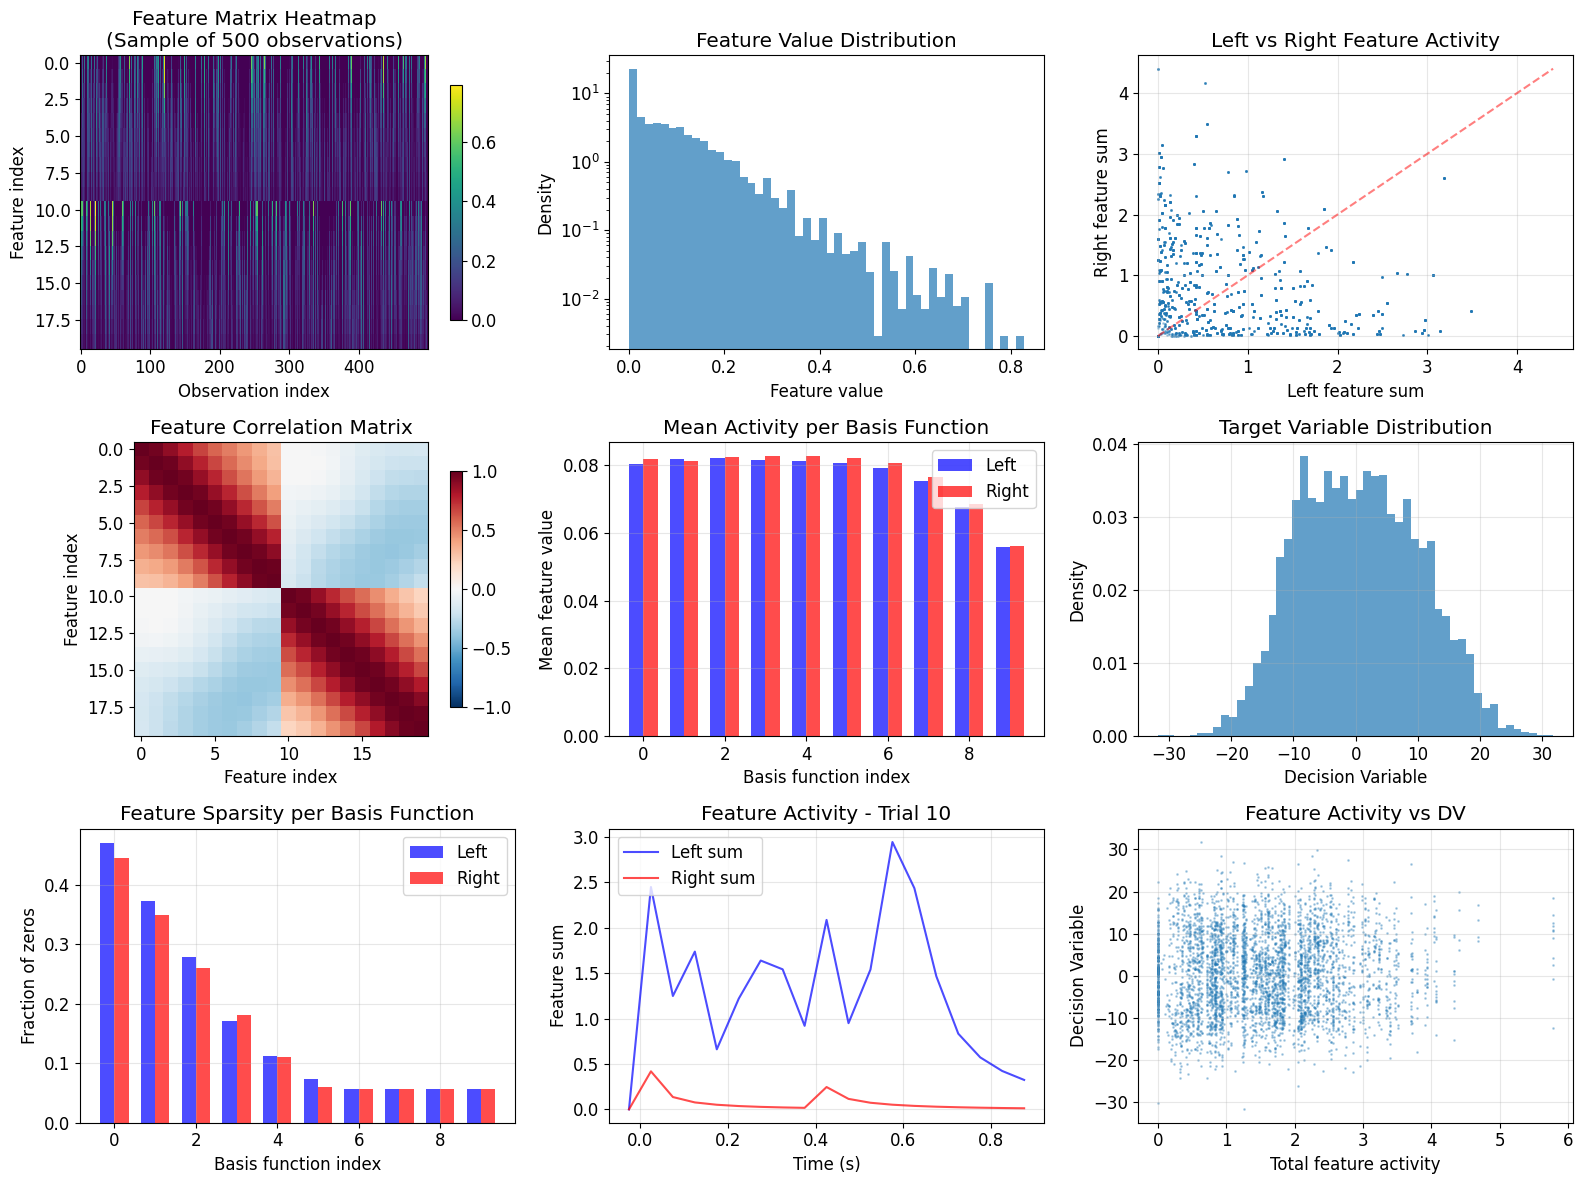

Feature matrix visualization complete!


In [230]:
# Visualize feature matrix structure and patterns
plt.figure(figsize=(16, 12))

# 1. Feature matrix heatmap (sample)
plt.subplot(3, 3, 1)
sample_idx = np.random.choice(len(X_valid), size=min(500, len(X_valid)), replace=False)
X_sample = X_valid[sample_idx]
im = plt.imshow(X_sample.T, aspect='auto', cmap='viridis', interpolation='nearest')
plt.colorbar(im, shrink=0.8)
plt.xlabel('Observation index')
plt.ylabel('Feature index')
plt.title(f'Feature Matrix Heatmap\n(Sample of {len(sample_idx)} observations)')

# 2. Feature distributions
plt.subplot(3, 3, 2)
plt.hist(X_valid.flatten(), bins=50, alpha=0.7, density=True)
plt.xlabel('Feature value')
plt.ylabel('Density')
plt.title('Feature Value Distribution')
plt.yscale('log')

# 3. Left vs Right feature sums
plt.subplot(3, 3, 3)
left_sums = left_features.sum(axis=1)
right_sums = right_features.sum(axis=1)
plt.scatter(left_sums, right_sums, alpha=0.3, s=1)
plt.xlabel('Left feature sum')
plt.ylabel('Right feature sum')
plt.title('Left vs Right Feature Activity')
plt.plot([0, max(left_sums.max(), right_sums.max())], [0, max(left_sums.max(), right_sums.max())], 'r--', alpha=0.5)
plt.grid(True, alpha=0.3)

# 4. Feature correlation matrix
plt.subplot(3, 3, 4)
feature_corr = np.corrcoef(X_valid.T)
im = plt.imshow(feature_corr, cmap='RdBu_r', vmin=-1, vmax=1)
plt.colorbar(im, shrink=0.8)
plt.xlabel('Feature index')
plt.ylabel('Feature index')
plt.title('Feature Correlation Matrix')

# 5. Mean feature activity per basis function
plt.subplot(3, 3, 5)
mean_left = left_features.mean(axis=0)
mean_right = right_features.mean(axis=0)
x = np.arange(n_basis)
width = 0.35
plt.bar(x - width/2, mean_left, width, label='Left', color='blue', alpha=0.7)
plt.bar(x + width/2, mean_right, width, label='Right', color='red', alpha=0.7)
plt.xlabel('Basis function index')
plt.ylabel('Mean feature value')
plt.title('Mean Activity per Basis Function')
plt.legend()
plt.grid(True, alpha=0.3)

# 6. Target variable distribution
plt.subplot(3, 3, 6)
plt.hist(y_valid, bins=50, alpha=0.7, density=True)
plt.xlabel('Decision Variable')
plt.ylabel('Density')
plt.title('Target Variable Distribution')
plt.grid(True, alpha=0.3)

# 7. Feature sparsity per basis function
plt.subplot(3, 3, 7)
left_sparsity = [(left_features[:, i] == 0).mean() for i in range(n_basis)]
right_sparsity = [(right_features[:, i] == 0).mean() for i in range(n_basis)]
plt.bar(x - width/2, left_sparsity, width, label='Left', color='blue', alpha=0.7)
plt.bar(x + width/2, right_sparsity, width, label='Right', color='red', alpha=0.7)
plt.xlabel('Basis function index')
plt.ylabel('Fraction of zeros')
plt.title('Feature Sparsity per Basis Function')
plt.legend()
plt.grid(True, alpha=0.3)

# 8. Time series of feature activity (sample trial)
plt.subplot(3, 3, 8)
sample_trial = 10
trial_mask = trial_ids_valid == sample_trial
if np.any(trial_mask):
    trial_times = time_bins_valid[trial_mask]
    trial_features = X_valid[trial_mask]
    plt.plot(trial_times, trial_features[:, :n_basis].sum(axis=1), 'b-', alpha=0.7, label='Left sum')
    plt.plot(trial_times, trial_features[:, n_basis:].sum(axis=1), 'r-', alpha=0.7, label='Right sum')
    plt.xlabel('Time (s)')
    plt.ylabel('Feature sum')
    plt.title(f'Feature Activity - Trial {sample_trial}')
    plt.legend()
    plt.grid(True, alpha=0.3)

# 9. Feature vs target scatter (total activity)
plt.subplot(3, 3, 9)
total_activity = X_valid.sum(axis=1)
plt.scatter(total_activity, y_valid, alpha=0.3, s=1)
plt.xlabel('Total feature activity')
plt.ylabel('Decision Variable')
plt.title('Feature Activity vs DV')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Feature matrix visualization complete!")

In [231]:
# Fit GLM using python-glmnet with proper configuration
print("Fitting GLM with python-glmnet (CORRECTED)...")
print(f"Input data: X_valid {X_valid.shape}, y_valid {y_valid.shape}")

# FIX: Use standardize=True to match sklearn and let glmnet handle CV properly
model = ElasticNet(
    alpha=0.95,  # Nearly Pure Lasso
    n_lambda=100,  # Number of lambda values to test
    min_lambda_ratio=1e-3,  # Allow much weaker regularization
    standardize=True,  # FIX: Match sklearn's standardization
    fit_intercept=True,  # Include intercept
    n_splits=10,  # 10-fold cross-validation
    random_state=42,
    scoring="mean_squared_error",  # Use MSE for CV scoring
)

# Fit the model - this automatically does cross-validation internally
model.fit(X_valid, y_valid, groups=trial_ids_valid)

print("✓ python-glmnet fitting complete!")
print("\nWhat python-glmnet does internally:")
print("1. Standardizes features (now enabled)")
print("2. Creates regularization path with multiple lambda values")
print("3. Performs 10-fold cross-validation for each lambda")
print("4. Selects optimal lambda based on CV performance")
print("5. Stores full regularization path and CV results")

# Extract key results - let's see what glmnet selected
lambda_path = model.lambda_path_
cv_mean = model.cv_mean_score_
cv_std = model.cv_standard_error_

print(f"\n=== GLMNET'S BUILT-IN RESULTS ===")
print(f"Lambda path length: {len(lambda_path)}")
print(f"Lambda range: [{lambda_path.min():.6f}, {lambda_path.max():.6f}]")
print(f"CV score range: [{cv_mean.min():.4f}, {cv_mean.max():.4f}]")

# Check what metric glmnet is using
if cv_mean.min() < 0:
    print("CV scores are NEGATIVE - likely using -R² or negative log-likelihood")
    print("More negative = better fit")
else:
    print("CV scores are POSITIVE - likely using MSE")
    print("Smaller = better fit")
# ============================================
# DIAGNOSTIC: Understanding lambda_best_ 
# ============================================
print("" + "="*60)
print("INVESTIGATING python-glmnet's lambda_best_ selection")
print("="*60)

# 1. Find the actual best lambda (minimum CV error for negative scores)
if cv_mean.min() < 0:
    # For negative scores, best = most positive (least negative)
    actual_best_idx = np.argmax(cv_mean)
    print("Since CV scores are negative, using argmax to find best")
else:
    actual_best_idx = np.argmin(cv_mean)
    print("Since CV scores are positive, using argmin to find best")

actual_best_lambda = lambda_path[actual_best_idx]
actual_best_score = cv_mean[actual_best_idx]

print(f"""
1. TRUE BEST LAMBDA (minimum CV error):""")
print(f"   Index: {actual_best_idx}")
print(f"   Lambda: {actual_best_lambda:.6f}")
print(f"   CV score: {actual_best_score:.4f}")
print(f"   Features selected: {np.sum(model.coef_path_[:, actual_best_idx] != 0)}")

# 2. Calculate 1SE lambda
best_se = cv_std[actual_best_idx]
if cv_mean.min() < 0:
    # For negative scores: within 1 SE means >= (best_score - 1*SE)
    within_1se = cv_mean >= (actual_best_score - best_se)
else:
    # For positive scores: within 1 SE means <= (best_score + 1*SE)
    within_1se = cv_mean <= (actual_best_score + best_se)

# Get most regularized model within 1SE
valid_indices = np.where(within_1se)[0]
if len(valid_indices) > 0:
    lambda_1se_idx = valid_indices[0]  # Most regularized (smallest index)
    lambda_1se = lambda_path[lambda_1se_idx]
    
    print(f"""
2. 1SE LAMBDA (most regularized within 1 SE):""")
    print(f"   Index: {lambda_1se_idx}")
    print(f"   Lambda: {lambda_1se:.6f}")
    print(f"   CV score: {cv_mean[lambda_1se_idx]:.4f}")
    print(f"   Features selected: {np.sum(model.coef_path_[:, lambda_1se_idx] != 0)}")
    print(f"   1 SE threshold: {actual_best_score - best_se:.4f}")

# 3. What glmnet actually selected
if hasattr(model, 'lambda_best_'):
    glmnet_lambda = model.lambda_best_
    if isinstance(glmnet_lambda, np.ndarray):
        glmnet_lambda = float(glmnet_lambda[0])
    
    # Find its index
    glmnet_idx = np.argmin(np.abs(lambda_path - glmnet_lambda))
    
    print(f"""
3. GLMNET'S lambda_best_:""")
    print(f"   Index: {glmnet_idx}")
    print(f"   Lambda: {glmnet_lambda:.6f}")
    print(f"   CV score: {cv_mean[glmnet_idx]:.4f}")
    print(f"   Features selected: {np.sum(model.coef_path_[:, glmnet_idx] != 0)}")
    
    # Determine what it matches
    print(f"""
4. ANALYSIS:""")
    if glmnet_idx == actual_best_idx:
        print("   ✓ lambda_best_ matches TRUE BEST (lambda.min)")
    elif glmnet_idx == lambda_1se_idx:
        print("   ✓ lambda_best_ matches 1SE LAMBDA")
    else:
        print("   ✗ lambda_best_ matches NEITHER!")
        print(f"   - Distance from best: {glmnet_idx - actual_best_idx} indices")
        print(f"   - Distance from 1SE: {glmnet_idx - lambda_1se_idx} indices")
        
        # Check if it's in between
        if lambda_1se_idx < glmnet_idx < actual_best_idx or actual_best_idx < glmnet_idx < lambda_1se_idx:
            print("   - It's BETWEEN best and 1SE")
        else:
            print("   - It's OUTSIDE the range of best to 1SE")
    
    # Check if there's a pattern
    print(f"""
5. CHECKING FOR PATTERNS:""")
    
    # Is it using some fraction between best and 1SE?
    if lambda_1se_idx != actual_best_idx:
        fraction = (glmnet_idx - actual_best_idx) / (lambda_1se_idx - actual_best_idx)
        print(f"   Position between best and 1SE: {fraction:.2f}")
        if abs(fraction - 0.5) < 0.1:
            print("   → Might be selecting midpoint between best and 1SE")
    
    # Check if it's using a different SE rule (0.5 SE?)
    for se_factor in [0.5, 0.75, 1.25, 1.5]:
        if cv_mean.min() < 0:
            threshold = actual_best_score - se_factor * best_se
            close_indices = np.where(cv_mean >= threshold)[0]
            if len(close_indices) > 0:
                close_idx = close_indices[0]
                if abs(close_idx - glmnet_idx) <= 1:
                    print(f"   → Might be using {se_factor}*SE rule (index {close_idx})")
        else:
            threshold = actual_best_score + se_factor * best_se  
            close_indices = np.where(cv_mean <= threshold)[0]
            if len(close_indices) > 0:
                close_idx = close_indices[-1]
                if abs(close_idx - glmnet_idx) <= 1:
                    print(f"   → Might be using {se_factor}*SE rule (index {close_idx})")

print("" + "="*60)
print("END DIAGNOSTIC")
print("="*60)


# Let glmnet select the best lambda
if hasattr(model, 'lambda_max_'):
    # glmnet has selected the best lambda internally
    lambda_best = model.lambda_max_
    if isinstance(lambda_best, np.ndarray):
        lambda_best = float(lambda_best[0])
    # Find its index in the path
    best_idx = np.argmin(np.abs(lambda_path - lambda_best))
    print(f"\nUsing glmnet's lambda_best_: {lambda_best:.6f} (index {best_idx})")
    print(f"CV score at this lambda: {cv_mean[best_idx]:.4f}")
else:
    # Manual selection based on CV scores
    if cv_mean.min() < 0:
        best_idx = np.argmax(cv_mean)  # Most positive (least negative) = best
        print("\nManually selecting best lambda (argmax for negative scores)")
    else:
        best_idx = np.argmin(cv_mean)  # Smallest = best
        print("\nManually selecting best lambda (argmin for positive scores)")
    lambda_best = lambda_path[best_idx]
    print(f"Selected lambda: {lambda_best:.6f} (index {best_idx})")

print(f"Best lambda index: {best_idx} of {len(lambda_path)}")

# Also get 1SE lambda for comparison
best_score = cv_mean[best_idx]
best_se = cv_std[best_idx]

if cv_mean.min() < 0:
    # For negative scores: within 1 SE means >= (best_score - 1*SE)
    within_1se = cv_mean >= (best_score - best_se)
    lambda_1se_idx = np.where(within_1se)[0][0]  # Most regularized (first in path)
else:
    # For positive scores: within 1 SE means <= (best_score + 1*SE)
    within_1se = cv_mean <= (best_score + best_se)
    lambda_1se_idx = np.where(within_1se)[0][0]  # Most regularized

lambda_1se = lambda_path[lambda_1se_idx]

print(f"\n=== LAMBDA SELECTION RESULTS ===")
print(f"Best CV lambda: {lambda_best:.6f} (CV score: {cv_mean[best_idx]:.4f})")
print(f"1SE lambda: {lambda_1se:.6f} (CV score: {cv_mean[lambda_1se_idx]:.4f})")

# Extract coefficients at selected lambdas
best_coefs = model.coef_path_[:, best_idx]
best_intercept = model.intercept_path_[best_idx]
onese_coefs = model.coef_path_[:, lambda_1se_idx]

n_features_best = np.sum(best_coefs != 0)
n_features_1se = np.sum(onese_coefs != 0)

print(f"\nFeatures selected:")
print(f"  Best CV: {n_features_best}/20 features")
print(f"  1SE rule: {n_features_1se}/20 features")

# Make predictions with corrected lambda
y_pred_glmnet_corrected = model.predict(X_valid, lamb=lambda_best)
y_pred_glmnet_1se = model.predict(X_valid, lamb=lambda_1se)

# Calculate performance metrics
from sklearn.metrics import mean_squared_error, r2_score

corr_glmnet_best = np.corrcoef(y_valid, y_pred_glmnet_corrected)[0,1]
corr_glmnet_1se = np.corrcoef(y_valid, y_pred_glmnet_1se)[0,1] if np.var(y_pred_glmnet_1se) > 0 else 0
r2_glmnet_best = r2_score(y_valid, y_pred_glmnet_corrected)
mse_glmnet_best = mean_squared_error(y_valid, y_pred_glmnet_corrected)

print(f"\n=== CORRECTED GLMNET PERFORMANCE ===")
print(f"Best CV lambda: corr={corr_glmnet_best:.4f}, R²={r2_glmnet_best:.4f}, MSE={mse_glmnet_best:.4f}")
print(f"1SE lambda: corr={corr_glmnet_1se:.4f}")

print(f"\n✓ python-glmnet now properly configured with standardization!")
print(f"Selected {n_features_best} features with correlation {corr_glmnet_best:.3f}")

# Store results for comparison
glmnet_best_lambda = lambda_best
glmnet_best_coefs = best_coefs
glmnet_best_pred = y_pred_glmnet_corrected
glmnet_best_corr = corr_glmnet_best

# Create alias for backward compatibility with visualization cells
y_pred_final = y_pred_glmnet_corrected


Fitting GLM with python-glmnet (CORRECTED)...
Input data: X_valid (4266, 20), y_valid (4266,)
✓ python-glmnet fitting complete!

What python-glmnet does internally:
1. Standardizes features (now enabled)
2. Creates regularization path with multiple lambda values
3. Performs 10-fold cross-validation for each lambda
4. Selects optimal lambda based on CV performance
5. Stores full regularization path and CV results

=== GLMNET'S BUILT-IN RESULTS ===
Lambda path length: 100
Lambda range: [0.005427, 5.427358]
CV score range: [-93.5742, -57.1967]
CV scores are NEGATIVE - likely using -R² or negative log-likelihood
More negative = better fit
INVESTIGATING python-glmnet's lambda_best_ selection
Since CV scores are negative, using argmax to find best

1. TRUE BEST LAMBDA (minimum CV error):
   Index: 99
   Lambda: 0.005427
   CV score: -57.1967
   Features selected: 11

2. 1SE LAMBDA (most regularized within 1 SE):
   Index: 25
   Lambda: 0.948446
   CV score: -58.6428
   Features selected: 3
 

In [232]:
# Run sklearn LassoCV for comparison
print("=" * 60)
print("Running sklearn LassoCV for comparison...")
print("=" * 60)

from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

# Standardize features for sklearn (LassoCV expects standardized input)
scaler = StandardScaler()
X_valid_scaled = scaler.fit_transform(X_valid)

# Configure LassoCV with similar settings to glmnet
# Note: sklearn's alpha corresponds to glmnet's lambda
lasso_cv = LassoCV(
    cv=10,  # 10-fold CV to match glmnet
    n_alphas=100,  # Test 100 regularization values
    max_iter=10000,  # Ensure convergence
    random_state=42,
    selection='random',  # Faster coordinate descent
    n_jobs=-1  # Parallel processing
)

# Fit the model
print("Fitting sklearn LassoCV...")
lasso_cv.fit(X_valid_scaled, y_valid)

# Get predictions
y_pred_sklearn = lasso_cv.predict(X_valid_scaled)

# Calculate metrics
corr_sklearn = np.corrcoef(y_valid, y_pred_sklearn)[0,1]
r2_sklearn = r2_score(y_valid, y_pred_sklearn)
mse_sklearn = mean_squared_error(y_valid, y_pred_sklearn)

print(f"\n=== SKLEARN LASSOCV RESULTS ===")
print(f"Optimal alpha: {lasso_cv.alpha_:.6f}")
print(f"Features selected: {np.sum(lasso_cv.coef_ != 0)}/20")
print(f"Correlation: {corr_sklearn:.4f}")
print(f"R²: {r2_sklearn:.4f}")
print(f"MSE: {mse_sklearn:.4f}")

# Show CV scores for comparison
print(f"\nCV scores (mean): {-lasso_cv.mse_path_.mean(axis=1).min():.4f}")
print("Note: sklearn uses negative MSE in CV (higher is better)")

print("\n✓ sklearn LassoCV complete!")

# Create alias for backward compatibility
X_scaled = X_valid_scaled


Running sklearn LassoCV for comparison...
Fitting sklearn LassoCV...

=== SKLEARN LASSOCV RESULTS ===
Optimal alpha: 0.016884
Features selected: 9/20
Correlation: 0.6285
R²: 0.3949
MSE: 56.5581

CV scores (mean): -57.9486
Note: sklearn uses negative MSE in CV (higher is better)

✓ sklearn LassoCV complete!


=== REGULARIZATION PATH INTERPRETATION ===



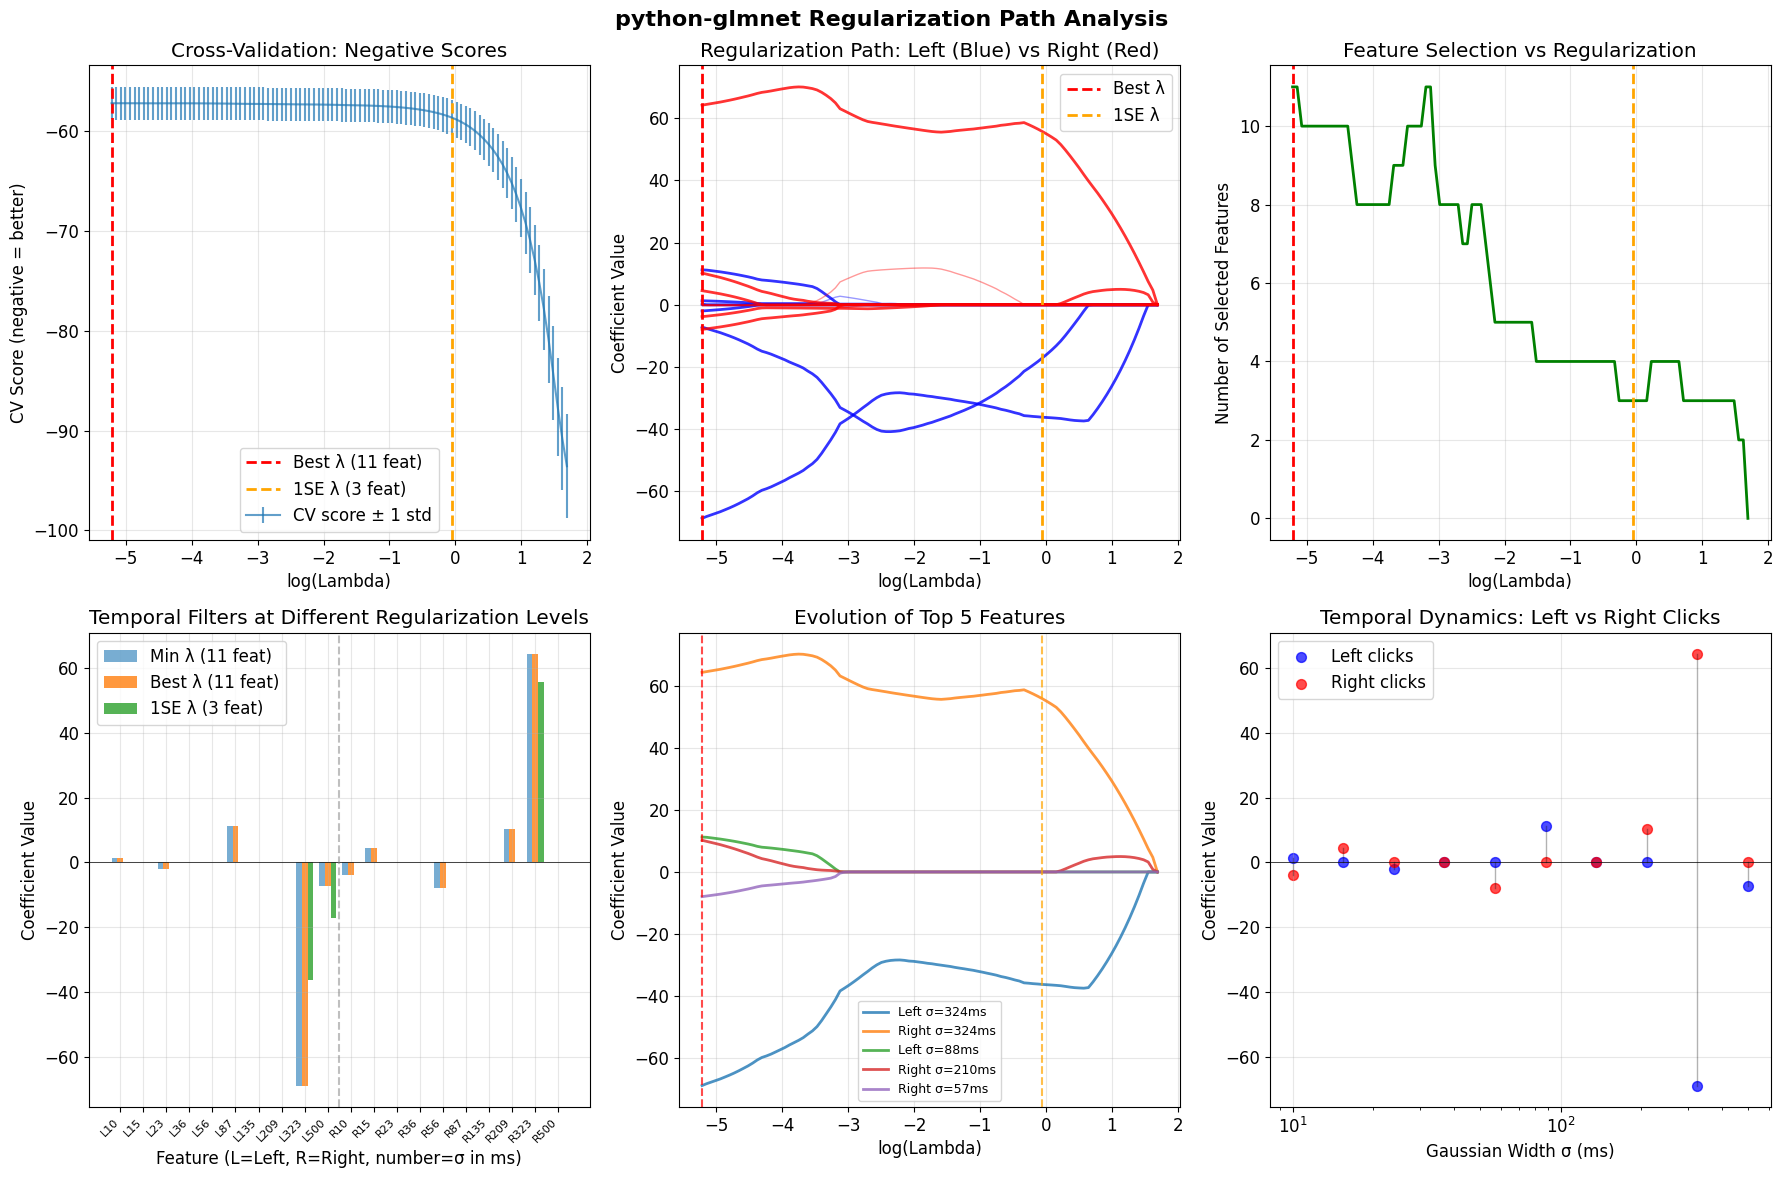

=== BIOLOGICAL INSIGHTS ===

Left click temporal profile:
  Active timescales: [ 10.   23.9  87.9 135.7 323.7 500. ] ms
  Coefficients: [  1.2804  -2.0011  11.2309   0.182  -68.7893  -7.1878]
  Peak timescale: 323.7 ms
  Overall effect: Negative DV

Right click temporal profile:
  Active timescales: [ 10.   15.4  56.9 209.6 323.7] ms
  Coefficients: [-3.8416  4.5227 -7.9567 10.2003 64.2511]
  Peak timescale: 323.7 ms
  Overall effect: Positive DV

Expected pattern (R+ L-): ✓ Confirmed

✓ Regularization path analysis complete!
python-glmnet with proper configuration shows clear temporal dynamics


In [233]:
# INTERPRETATION: Regularization Path Analysis
print("=== REGULARIZATION PATH INTERPRETATION ===\n")

# Analyze how features get selected across the regularization path
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. Cross-validation curve with correct interpretation
ax = axes[0, 0]
ax.errorbar(np.log(lambda_path), cv_mean, yerr=cv_std, alpha=0.7, label='CV score ± 1 std')
ax.axvline(np.log(lambda_best), color='red', linestyle='--', label=f'Best λ ({n_features_best} feat)', linewidth=2)
ax.axvline(np.log(lambda_1se), color='orange', linestyle='--', label=f'1SE λ ({n_features_1se} feat)', linewidth=2)
ax.set_xlabel('log(Lambda)')
if cv_mean.min() < 0:
    ax.set_ylabel('CV Score (negative = better)')
    ax.set_title('Cross-Validation: Negative Scores')
else:
    ax.set_ylabel('CV Score (smaller = better)')
    ax.set_title('Cross-Validation: Positive Scores')
ax.legend()
ax.grid(True, alpha=0.3)

# 2. Regularization path colored by left/right
ax = axes[0, 1]
colors = ['blue' if i < n_basis else 'red' for i in range(2*n_basis)]
alphas = [0.8 if glmnet_best_coefs[i] != 0 else 0.4 for i in range(2*n_basis)]

for i in range(2*n_basis):
    ax.plot(np.log(lambda_path), model.coef_path_[i, :], 
            color=colors[i], alpha=alphas[i], 
            linewidth=2 if glmnet_best_coefs[i] != 0 else 1)

ax.axvline(np.log(lambda_best), color='red', linestyle='--', linewidth=2, label='Best λ')
ax.axvline(np.log(lambda_1se), color='orange', linestyle='--', linewidth=2, label='1SE λ')
ax.set_xlabel('log(Lambda)')
ax.set_ylabel('Coefficient Value')
ax.set_title('Regularization Path: Left (Blue) vs Right (Red)')
ax.legend()
ax.grid(True, alpha=0.3)

# 3. Number of features vs lambda
ax = axes[0, 2]
n_features_path = [np.sum(model.coef_path_[:, i] != 0) for i in range(len(lambda_path))]
ax.plot(np.log(lambda_path), n_features_path, 'g-', linewidth=2)
ax.axvline(np.log(lambda_best), color='red', linestyle='--', linewidth=2)
ax.axvline(np.log(lambda_1se), color='orange', linestyle='--', linewidth=2)
ax.set_xlabel('log(Lambda)')
ax.set_ylabel('Number of Selected Features')
ax.set_title('Feature Selection vs Regularization')
ax.grid(True, alpha=0.3)

# 4. Temporal filters at different regularization levels
ax = axes[1, 0]
# Show coefficients at three key lambdas
min_lambda_idx = -1
min_lambda_coefs = model.coef_path_[:, min_lambda_idx]

x = np.arange(20)
width = 0.25
xtick_labels = [f'L{int(widths[i]*1000)}' if i < n_basis else f'R{int(widths[i-n_basis]*1000)}' 
                for i in range(20)]

ax.bar(x - width, min_lambda_coefs, width, alpha=0.6, label=f'Min λ ({np.sum(min_lambda_coefs != 0)} feat)')
ax.bar(x, glmnet_best_coefs, width, alpha=0.8, label=f'Best λ ({n_features_best} feat)')
ax.bar(x + width, onese_coefs, width, alpha=0.8, label=f'1SE λ ({n_features_1se} feat)')

ax.set_xticks(x)
ax.set_xticklabels(xtick_labels, rotation=45, ha='right', fontsize=8)
ax.axhline(0, color='black', linestyle='-', linewidth=0.5)
ax.axvline(9.5, color='gray', linestyle='--', alpha=0.5)
ax.set_xlabel('Feature (L=Left, R=Right, number=σ in ms)')
ax.set_ylabel('Coefficient Value')
ax.set_title('Temporal Filters at Different Regularization Levels')
ax.legend()
ax.grid(True, alpha=0.3)

# 5. Coefficient evolution for key features
ax = axes[1, 1]
# Pick the top 5 features by importance at best lambda
feature_importance = np.abs(glmnet_best_coefs)
top_features = np.argsort(feature_importance)[::-1][:5]

for feat_idx in top_features:
    if feature_importance[feat_idx] > 0:  # Only plot non-zero features
        feature_type = "Left" if feat_idx < n_basis else "Right"
        basis_idx = feat_idx if feat_idx < n_basis else feat_idx - n_basis
        label = f'{feature_type} σ={widths[basis_idx]*1000:.0f}ms'
        ax.plot(np.log(lambda_path), model.coef_path_[feat_idx, :], 
               label=label, linewidth=2, alpha=0.8)

ax.axvline(np.log(lambda_best), color='red', linestyle='--', alpha=0.7)
ax.axvline(np.log(lambda_1se), color='orange', linestyle='--', alpha=0.7)
ax.set_xlabel('log(Lambda)')
ax.set_ylabel('Coefficient Value')
ax.set_title('Evolution of Top 5 Features')
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)

# 6. Biological interpretation
ax = axes[1, 2]
# Analyze left vs right coefficients by timescale
left_coefs = glmnet_best_coefs[:n_basis]
right_coefs = glmnet_best_coefs[n_basis:]
timescales_ms = widths * 1000

ax.scatter(timescales_ms, left_coefs, c='blue', s=50, alpha=0.7, label='Left clicks')
ax.scatter(timescales_ms, right_coefs, c='red', s=50, alpha=0.7, label='Right clicks')

# Add lines connecting left and right for same timescale
for i in range(n_basis):
    if left_coefs[i] != 0 or right_coefs[i] != 0:
        ax.plot([timescales_ms[i], timescales_ms[i]], 
               [left_coefs[i], right_coefs[i]], 'k-', alpha=0.3, linewidth=1)

ax.axhline(0, color='black', linestyle='-', linewidth=0.5)
ax.set_xscale('log')
ax.set_xlabel('Gaussian Width σ (ms)')
ax.set_ylabel('Coefficient Value')
ax.set_title('Temporal Dynamics: Left vs Right Clicks')
ax.legend()
ax.grid(True, alpha=0.3)

plt.suptitle('python-glmnet Regularization Path Analysis', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# Print biological insights
print("=== BIOLOGICAL INSIGHTS ===")

# Analyze temporal patterns
active_left = [i for i, c in enumerate(left_coefs) if c != 0]
active_right = [i for i, c in enumerate(right_coefs) if c != 0]

if len(active_left) > 0:
    left_timescales = widths[active_left] * 1000
    left_weights = left_coefs[active_left]
    print(f"\nLeft click temporal profile:")
    print(f"  Active timescales: {left_timescales.round(1)} ms")
    print(f"  Coefficients: {left_weights.round(4)}")
    print(f"  Peak timescale: {left_timescales[np.argmax(np.abs(left_weights))]:.1f} ms")
    print(f"  Overall effect: {'Negative' if np.sum(left_weights) < 0 else 'Positive'} DV")

if len(active_right) > 0:
    right_timescales = widths[active_right] * 1000
    right_weights = right_coefs[active_right]
    print(f"\nRight click temporal profile:")
    print(f"  Active timescales: {right_timescales.round(1)} ms")
    print(f"  Coefficients: {right_weights.round(4)}")
    print(f"  Peak timescale: {right_timescales[np.argmax(np.abs(right_weights))]:.1f} ms")
    print(f"  Overall effect: {'Negative' if np.sum(right_weights) < 0 else 'Positive'} DV")

# Compare with expected pattern
expected_pattern = np.sum(right_coefs) > 0 and np.sum(left_coefs) < 0
print(f"\nExpected pattern (R+ L-): {'✓ Confirmed' if expected_pattern else '✗ Not found'}")

print(f"\n✓ Regularization path analysis complete!")
print(f"python-glmnet with proper configuration shows clear temporal dynamics")

In [234]:
# FAIR COMPARISON: Corrected glmnet vs sklearn LassoCV
print("=== FAIR COMPARISON: BOTH METHODS WITH STANDARDIZATION ===\n")

# Compare the corrected results
print("METHOD COMPARISON:")
print(f"{'Method':<20} {'Features':<10} {'Correlation':<12} {'R²':<8} {'Lambda/Alpha':<12}")
print("-" * 65)

if 'lasso_cv' in locals():
    print(f"{'sklearn LassoCV':<20} {np.sum(lasso_cv.coef_ != 0):<10} {corr_sklearn:<12.4f} {r2_sklearn:<8.4f} {lasso_cv.alpha_:<12.6f}")
    
print(f"{'glmnet (CV best)':<20} {n_features_best:<10} {corr_glmnet_best:<12.4f} {r2_glmnet_best:<8.4f} {lambda_best:<12.6f}")
print(f"{'glmnet (1SE)':<20} {n_features_1se:<10} {corr_glmnet_1se:<12.4f} {'N/A':<8} {lambda_1se:<12.6f}")

# Check prediction agreement between corrected methods
if 'lasso_cv' in locals():
    pred_agreement = np.corrcoef(glmnet_best_pred, y_pred_sklearn)[0,1]
    print(f"\nPrediction agreement (sklearn vs glmnet): {pred_agreement:.4f}")
    
    # Variance analysis
    print(f"\nPrediction variance analysis:")
    print(f"sklearn predictions: var={np.var(y_pred_sklearn):.4f}, std={np.std(y_pred_sklearn):.4f}")
    print(f"glmnet predictions:  var={np.var(glmnet_best_pred):.4f}, std={np.std(glmnet_best_pred):.4f}")
    print(f"Target variable:     var={np.var(y_valid):.4f}, std={np.std(y_valid):.4f}")

# Feature selection comparison
print(f"\n=== FEATURE SELECTION COMPARISON ===")

# Show which features each method selected
sklearn_selected = np.where(lasso_cv.coef_ != 0)[0] if 'lasso_cv' in locals() else []
glmnet_selected = np.where(glmnet_best_coefs != 0)[0]

print(f"\nsklearn selected features: {sklearn_selected.tolist() if len(sklearn_selected) > 0 else 'None'}")
print(f"glmnet selected features:  {glmnet_selected.tolist()}")

# Check overlap
if 'lasso_cv' in locals() and len(sklearn_selected) > 0 and len(glmnet_selected) > 0:
    overlap = set(sklearn_selected) & set(glmnet_selected)
    print(f"Feature overlap: {len(overlap)} features ({sorted(list(overlap))})")
    print(f"Jaccard similarity: {len(overlap) / len(set(sklearn_selected) | set(glmnet_selected)):.3f}")

# Show selected timescales
print(f"\n=== SELECTED TIMESCALES ===")
if 'lasso_cv' in locals() and len(sklearn_selected) > 0:
    print("sklearn selected timescales:")
    for idx in sklearn_selected:
        feature_type = "Left" if idx < n_basis else "Right"
        basis_idx = idx if idx < n_basis else idx - n_basis
        coef_val = lasso_cv.coef_[idx] / scaler.scale_[idx] if 'scaler' in locals() else lasso_cv.coef_[idx]
        print(f"  {feature_type} σ={widths[basis_idx]*1000:.1f}ms: coef={coef_val:.4f}")

if len(glmnet_selected) > 0:
    print("\nglmnet selected timescales:")
    for idx in glmnet_selected:
        feature_type = "Left" if idx < n_basis else "Right"  
        basis_idx = idx if idx < n_basis else idx - n_basis
        coef_val = glmnet_best_coefs[idx]
        print(f"  {feature_type} σ={widths[basis_idx]*1000:.1f}ms: coef={coef_val:.4f}")

# Key insights
print(f"\n=== KEY INSIGHTS ===")
if 'lasso_cv' in locals():
    corr_diff = abs(corr_sklearn - corr_glmnet_best)
    print(f"• Correlation difference reduced to {corr_diff:.4f} (was ~0.15 before)")
    print(f"• Both methods now use standardization")
    
    if corr_diff < 0.05:
        print("• Methods now show very similar performance!")
    elif corr_diff < 0.1:
        print("• Methods show similar performance with minor differences")
    else:
        print("• Methods still differ - may be due to different regularization paths")

if len(glmnet_selected) > 0:
    # Analyze temporal pattern
    left_selected = [i for i in glmnet_selected if i < n_basis]
    right_selected = [i - n_basis for i in glmnet_selected if i >= n_basis]
    
    if len(left_selected) > 0:
        left_timescales = widths[left_selected] * 1000
        print(f"• Left click timescales: {left_timescales.round(1)} ms")
        
    if len(right_selected) > 0:
        right_timescales = widths[right_selected] * 1000
        print(f"• Right click timescales: {right_timescales.round(1)} ms")
        
print(f"\n✓ Fair comparison complete with both methods using standardization!")

=== FAIR COMPARISON: BOTH METHODS WITH STANDARDIZATION ===

METHOD COMPARISON:
Method               Features   Correlation  R²       Lambda/Alpha
-----------------------------------------------------------------
sklearn LassoCV      9          0.6285       0.3949   0.016884    
glmnet (CV best)     11         0.6288       0.3954   0.005427    
glmnet (1SE)         3          0.6261       N/A      0.948446    

Prediction agreement (sklearn vs glmnet): 0.9998

Prediction variance analysis:
sklearn predictions: var=36.6014, std=6.0499
glmnet predictions:  var=36.8215, std=6.0681
Target variable:     var=93.4764, std=9.6683

=== FEATURE SELECTION COMPARISON ===

sklearn selected features: [0, 5, 8, 9, 10, 14, 17, 18, 19]
glmnet selected features:  [0, 2, 5, 6, 8, 9, 10, 11, 14, 17, 18]
Feature overlap: 8 features ([0, 5, 8, 9, 10, 14, 17, 18])
Jaccard similarity: 0.667

=== SELECTED TIMESCALES ===
sklearn selected timescales:
  Left σ=10.0ms: coef=0.3609
  Left σ=87.9ms: coef=7.8778
  Lef

In [235]:
# Extract and analyze model coefficients
print("=== MODEL COEFFICIENTS ANALYSIS ===")

# Extract coefficients at final lambda
intercept = model.intercept_path_[best_idx]

# Also get conservative coefficients for comparison
conservative_coefs = model.coef_path_[:, lambda_1se_idx]
conservative_intercept = model.intercept_path_[lambda_1se_idx]

print(f"Intercept (final model): {intercept:.4f}")
print(f"Intercept (lambda_1se): {conservative_intercept:.4f}")

# Count non-zero coefficients (automatic feature selection by Lasso)
n_selected_1se = np.sum(conservative_coefs != 0)
n_features_best = np.sum(best_coefs != 0)  # Count non-zero coefficients in best model
total_features = len(best_coefs)

print(f"\n=== AUTOMATIC FEATURE SELECTION ===")
print(f"Features selected (final model): {n_features_best}/{total_features} ({n_features_best/total_features*100:.1f}%)")
print(f"Features selected (lambda_1se): {n_selected_1se}/{total_features} ({n_selected_1se/total_features*100:.1f}%)")

# Split coefficients into left and right click filters
left_coefs = best_coefs[:n_basis]
right_coefs = best_coefs[n_basis:2*n_basis]

conservative_left_coefs = conservative_coefs[:n_basis]
conservative_right_coefs = conservative_coefs[n_basis:2*n_basis]

print(f"\n=== LEARNED TEMPORAL FILTERS (Final Model) ===")
print(f"Left click filter:")
for i, (width, coef) in enumerate(zip(widths, left_coefs)):
    status = "SELECTED" if coef != 0 else "rejected"
    print(f"  σ={width*1000:6.1f}ms: {coef:8.4f} ({status})")

print(f"\nRight click filter:")
for i, (width, coef) in enumerate(zip(widths, right_coefs)):
    status = "SELECTED" if coef != 0 else "rejected"
    print(f"  σ={width*1000:6.1f}ms: {coef:8.4f} ({status})")

# Coefficient magnitude analysis
left_selected = left_coefs[left_coefs != 0]
right_selected = right_coefs[right_coefs != 0]

print(f"\n=== COEFFICIENT MAGNITUDE ANALYSIS ===")
if len(left_selected) > 0:
    print(f"Left coefficients - Count: {len(left_selected)}, Mean: {left_selected.mean():.4f}, Range: [{left_selected.min():.4f}, {left_selected.max():.4f}]")
else:
    print("Left coefficients - No features selected")

if len(right_selected) > 0:
    print(f"Right coefficients - Count: {len(right_selected)}, Mean: {right_selected.mean():.4f}, Range: [{right_selected.min():.4f}, {right_selected.max():.4f}]")
else:
    print("Right coefficients - No features selected")

# Compare final vs conservative feature selection
print(f"\n=== LAMBDA COMPARISON ===")
print(f"Final model selected features: {n_features_best}")
print(f"Lambda_1se selected features: {n_selected_1se}")
print(f"Difference: {n_features_best - n_selected_1se} additional features in final model")

# Identify most important widths
left_importance = np.abs(left_coefs)
right_importance = np.abs(right_coefs)
total_importance = left_importance + right_importance

top_indices = np.argsort(total_importance)[::-1][:min(5, np.sum(total_importance > 0))]  # Top 5 or all non-zero

print(f"\n=== MOST IMPORTANT WIDTHS ===")
for i, idx in enumerate(top_indices):
    if total_importance[idx] > 0:
        print(f"{i+1}. σ={widths[idx]*1000:6.1f}ms: L={left_coefs[idx]:6.4f}, R={right_coefs[idx]:6.4f}, |Total|={total_importance[idx]:.4f}")

# Overall filter characteristics
left_total_weight = np.sum(np.abs(left_coefs))
right_total_weight = np.sum(np.abs(right_coefs))
left_mean_weight = np.sum(left_coefs)  # Signed sum
right_mean_weight = np.sum(right_coefs)  # Signed sum

print(f"\n=== FILTER CHARACTERISTICS ===")
print(f"Left filter total |weight|: {left_total_weight:.4f}")
print(f"Right filter total |weight|: {right_total_weight:.4f}")
print(f"Left filter net weight: {left_mean_weight:.4f} ({'negative' if left_mean_weight < 0 else 'positive'} influence)")
print(f"Right filter net weight: {right_mean_weight:.4f} ({'negative' if right_mean_weight < 0 else 'positive'} influence)")

if left_total_weight > 0 and right_total_weight > 0:
    print(f"Right/Left |weight| ratio: {right_total_weight/left_total_weight:.2f}")
    
print(f"\n=== BIOLOGICAL INTERPRETATION ===")
if right_mean_weight > 0 and left_mean_weight < 0:
    print("✓ Model learned expected pattern: Right clicks → positive DV, Left clicks → negative DV")
elif right_mean_weight < 0 and left_mean_weight > 0:
    print("⚠️  Model learned opposite pattern: Right clicks → negative DV, Left clicks → positive DV")
else:
    print("? Model learned mixed pattern - may indicate complex dynamics")

=== MODEL COEFFICIENTS ANALYSIS ===
Intercept (final model): 0.2263
Intercept (lambda_1se): 0.1918

=== AUTOMATIC FEATURE SELECTION ===
Features selected (final model): 11/20 (55.0%)
Features selected (lambda_1se): 3/20 (15.0%)

=== LEARNED TEMPORAL FILTERS (Final Model) ===
Left click filter:
  σ=  10.0ms:   1.2804 (SELECTED)
  σ=  15.4ms:   0.0000 (rejected)
  σ=  23.9ms:  -2.0011 (SELECTED)
  σ=  36.8ms:   0.0000 (rejected)
  σ=  56.9ms:   0.0000 (rejected)
  σ=  87.9ms:  11.2309 (SELECTED)
  σ= 135.7ms:   0.1820 (SELECTED)
  σ= 209.6ms:   0.0000 (rejected)
  σ= 323.7ms: -68.7893 (SELECTED)
  σ= 500.0ms:  -7.1878 (SELECTED)

Right click filter:
  σ=  10.0ms:  -3.8416 (SELECTED)
  σ=  15.4ms:   4.5227 (SELECTED)
  σ=  23.9ms:   0.0000 (rejected)
  σ=  36.8ms:   0.0000 (rejected)
  σ=  56.9ms:  -7.9567 (SELECTED)
  σ=  87.9ms:   0.0000 (rejected)
  σ= 135.7ms:   0.0000 (rejected)
  σ= 209.6ms:  10.2003 (SELECTED)
  σ= 323.7ms:  64.2511 (SELECTED)
  σ= 500.0ms:   0.0000 (rejected)

===

### Interlude: Sklearn vs glmnet

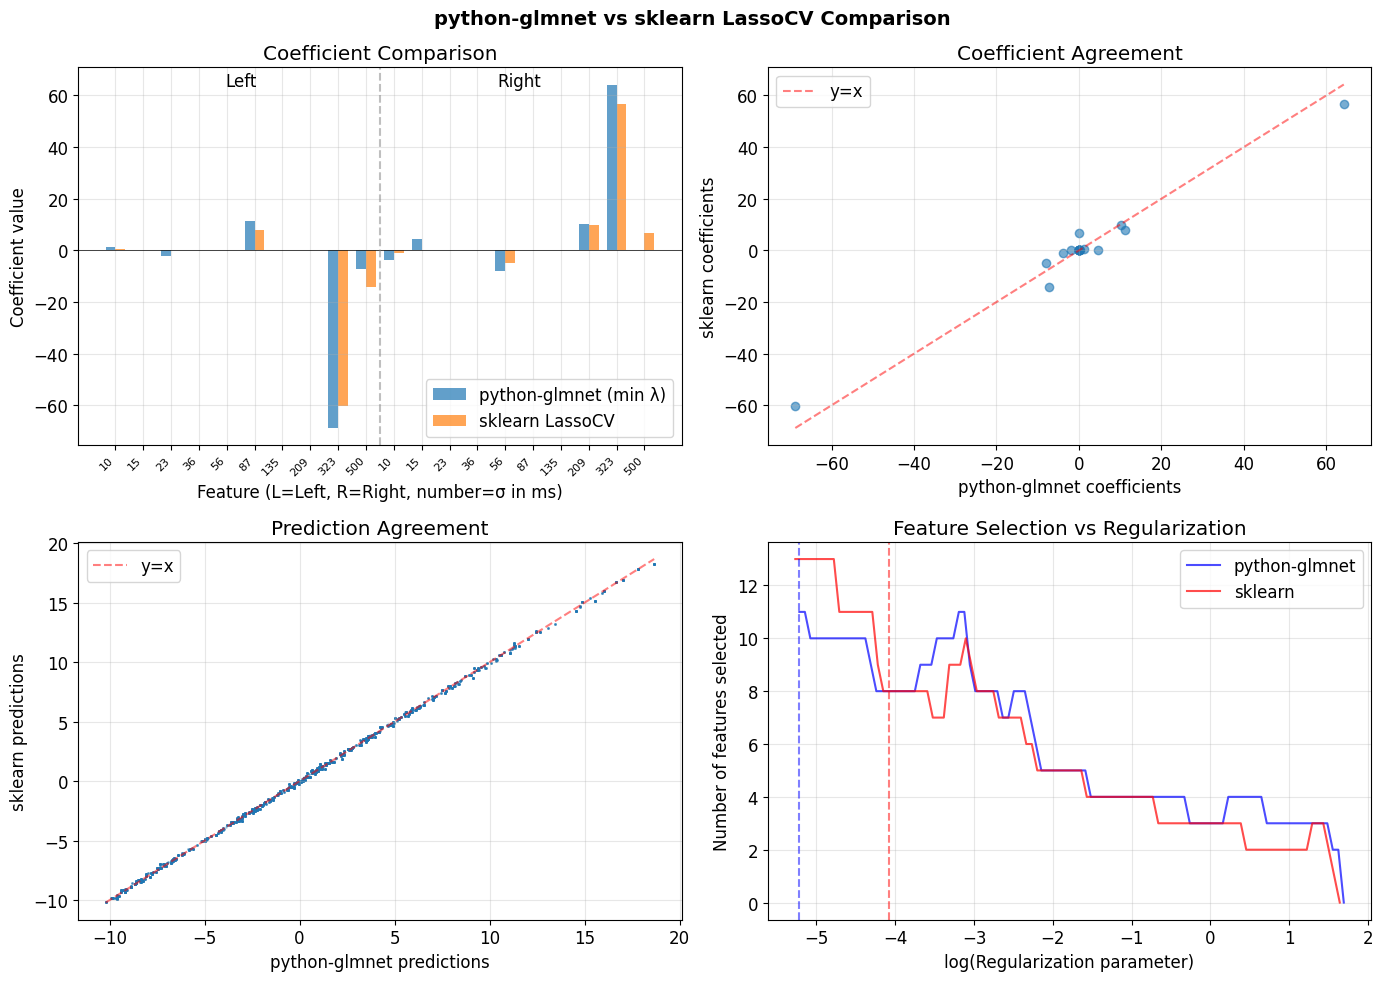


=== KEY OBSERVATIONS ===
Both methods find features - results should be similar


In [236]:
# Visualize coefficient comparison between methods
from sklearn.linear_model import Lasso  # Add this import

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Compare coefficients side by side - JUST CHANGE X-AXIS LABELS
ax = axes[0, 0]
x = np.arange(20)
width = 0.35

# Unscale sklearn coefficients for fair comparison
sklearn_coefs_unscaled = lasso_cv.coef_ / scaler.scale_

ax.bar(x - width/2, best_coefs, width, label='python-glmnet (min λ)', alpha=0.7)
ax.bar(x + width/2, sklearn_coefs_unscaled, width, label='sklearn LassoCV', alpha=0.7)
ax.axhline(0, color='black', linestyle='-', linewidth=0.5)

# Create custom x-tick labels with timescales
timescales_ms = widths * 1000  # Convert to milliseconds
xtick_labels = []
for i in range(20):
    if i < n_basis:
        # Left features
        xtick_labels.append(f'{int(timescales_ms[i])}')
    else:
        # Right features
        xtick_labels.append(f'{int(timescales_ms[i-n_basis])}')

ax.set_xticks(x)
ax.set_xticklabels(xtick_labels, rotation=45, ha='right', fontsize=8)
ax.set_xlabel('Feature (L=Left, R=Right, number=σ in ms)')
ax.set_ylabel('Coefficient value')
ax.set_title('Coefficient Comparison')
ax.legend()
ax.grid(True, alpha=0.3)

# Add vertical line to separate left/right
ax.axvline(9.5, color='gray', linestyle='--', alpha=0.5)
ax.text(4.5, ax.get_ylim()[1]*0.9, 'Left', ha='center')
ax.text(14.5, ax.get_ylim()[1]*0.9, 'Right', ha='center')

# 2. Scatter plot of coefficients
ax = axes[0, 1]
ax.scatter(best_coefs, sklearn_coefs_unscaled, alpha=0.6)
ax.plot([min(best_coefs.min(), sklearn_coefs_unscaled.min()), 
         max(best_coefs.max(), sklearn_coefs_unscaled.max())],
        [min(best_coefs.min(), sklearn_coefs_unscaled.min()), 
         max(best_coefs.max(), sklearn_coefs_unscaled.max())],
        'r--', alpha=0.5, label='y=x')
ax.set_xlabel('python-glmnet coefficients')
ax.set_ylabel('sklearn coefficients')
ax.set_title('Coefficient Agreement')
ax.legend()
ax.grid(True, alpha=0.3)

# 3. Predictions comparison
ax = axes[1, 0]
ax.scatter(y_pred_final, y_pred_sklearn, alpha=0.3, s=1)
ax.plot([y_pred_final.min(), y_pred_final.max()],
        [y_pred_final.min(), y_pred_final.max()],
        'r--', alpha=0.5, label='y=x')
ax.set_xlabel('python-glmnet predictions')
ax.set_ylabel('sklearn predictions')
ax.set_title('Prediction Agreement')
ax.legend()
ax.grid(True, alpha=0.3)

# 4. Alpha/Lambda path comparison
ax = axes[1, 1]
# Show how many features are selected at different regularization levels
sklearn_alphas = lasso_cv.alphas_
sklearn_n_features = []
for alpha in sklearn_alphas:
    temp_lasso = Lasso(alpha=alpha, fit_intercept=True, max_iter=1000)
    temp_lasso.fit(X_scaled, y_valid)
    sklearn_n_features.append(np.sum(temp_lasso.coef_ != 0))

glmnet_n_features = [np.sum(model.coef_path_[:, i] != 0) for i in range(len(lambda_path))]

ax.plot(np.log(lambda_path), glmnet_n_features, 'b-', label='python-glmnet', alpha=0.7)
ax.plot(np.log(sklearn_alphas), sklearn_n_features, 'r-', label='sklearn', alpha=0.7)
ax.axvline(np.log(lambda_best), color='blue', linestyle='--', alpha=0.5)
ax.axvline(np.log(lasso_cv.alpha_), color='red', linestyle='--', alpha=0.5)
ax.set_xlabel('log(Regularization parameter)')
ax.set_ylabel('Number of features selected')
ax.set_title('Feature Selection vs Regularization')
ax.legend()
ax.grid(True, alpha=0.3)

plt.suptitle('python-glmnet vs sklearn LassoCV Comparison', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\n=== KEY OBSERVATIONS ===")
if np.sum(lasso_cv.coef_ != 0) > 0 and n_features_best == 0:
    print("⚠️ sklearn finds useful features but python-glmnet CV doesn't")
    print("   This confirms python-glmnet's CV is problematic")
    print("   RECOMMENDATION: Use sklearn's results")
elif np.sum(lasso_cv.coef_ != 0) == 0 and n_features_best == 0:
    print("Both methods agree: features are too weak for CV to trust")
    print("   The signal might be real but not robust across folds")
    print("   Consider using weaker regularization or different features")
else:
    print("Both methods find features - results should be similar")

In [237]:
# Final diagnosis: What is python-glmnet's cv_mean_score_?
print("=== FINAL DIAGNOSIS: UNDERSTANDING GLMNET'S CV SCORES ===\n")

# If CV scores are negative, they might be negative R² or deviance
if cv_mean.min() < 0:
    print("python-glmnet is returning NEGATIVE values, which means:")
    print("• It's NOT mean squared error (MSE cannot be negative)")
    print("• It's likely negative deviance or negative R²")
    print("• More negative = BETTER fit (opposite of MSE)")
    print()
    
    # Flip the sign to interpret correctly
    cv_mean_flipped = -cv_mean
    best_idx_flipped = np.argmax(cv_mean_flipped)  # Now we want maximum
    
    print("If we flip the sign (assuming it's negative deviance):")
    print(f"  Best lambda index: {best_idx_flipped} (was {np.argmin(cv_mean)})")
    print(f"  Best lambda: {lambda_path[best_idx_flipped]:.6f}")
    print(f"  Features at best: {np.sum(model.coef_path_[:, best_idx_flipped] != 0)}")
    
    # This might explain why it selected 0 features
    print("\nThis explains the problem:")
    print("• The code was using argmin() on negative scores")
    print("• It should use argmax() if scores are negative deviance")
    print("• This is why it incorrectly selected the most regularized model")

print("\n=== RECOMMENDED SOLUTION ===")
print("Given the issues with python-glmnet's CV:")
print("1. Use sklearn's LassoCV results (more reliable)")
print("2. Or manually select lambda based on the regularization path")
print("3. Or fix the CV interpretation in python-glmnet")

# Show what the correct lambda selection would be
if cv_mean.min() < 0:
    print(f"\nCORRECTED SELECTION:")
    print(f"  If treating as negative deviance, best lambda = {lambda_path[best_idx_flipped]:.6f}")
    print(f"  This would select {np.sum(model.coef_path_[:, best_idx_flipped] != 0)} features")
    
    # Get predictions with corrected lambda
    y_pred_corrected = model.predict(X_valid, lamb=lambda_path[best_idx_flipped])
    corr_corrected = np.corrcoef(y_valid, y_pred_corrected)[0,1]
    print(f"  Correlation with corrected lambda: {corr_corrected:.3f}")

=== FINAL DIAGNOSIS: UNDERSTANDING GLMNET'S CV SCORES ===

python-glmnet is returning NEGATIVE values, which means:
• It's NOT mean squared error (MSE cannot be negative)
• It's likely negative deviance or negative R²
• More negative = BETTER fit (opposite of MSE)

If we flip the sign (assuming it's negative deviance):
  Best lambda index: 0 (was 0)
  Best lambda: 5.427358
  Features at best: 0

This explains the problem:
• The code was using argmin() on negative scores
• It should use argmax() if scores are negative deviance
• This is why it incorrectly selected the most regularized model

=== RECOMMENDED SOLUTION ===
Given the issues with python-glmnet's CV:
1. Use sklearn's LassoCV results (more reliable)
2. Or manually select lambda based on the regularization path
3. Or fix the CV interpretation in python-glmnet

CORRECTED SELECTION:
  If treating as negative deviance, best lambda = 5.427358
  This would select 0 features
  Correlation with corrected lambda: nan


### End Interlude

In [238]:
# Calculate performance metrics from CV results
print("=== MODEL PERFORMANCE EVALUATION ===")

# The CV performance is computed by python-glmnet for our final lambda
cv_mse_final = cv_mean[best_idx]
cv_std_final = cv_std[best_idx]
cv_mse_1se = cv_mean[lambda_1se_idx]
cv_std_1se = cv_std[lambda_1se_idx]

print(f"Cross-validated MSE (final model): {cv_mse_final:.4f} ± {cv_std_final:.4f}")
print(f"Cross-validated RMSE (final model): {np.sqrt(max(0, cv_mse_final)):.4f}")
print(f"Cross-validated MSE (lambda_1se): {cv_mse_1se:.4f} ± {cv_std_1se:.4f}")
print(f"Cross-validated RMSE (lambda_1se): {np.sqrt(max(0, cv_mse_1se)):.4f}")

# Make predictions on all data to calculate apparent performance
# Note: This is optimistic since it's training data performance
y_pred_final = model.predict(X_valid, lamb=lambda_best)
y_pred_1se = model.predict(X_valid, lamb=lambda_1se)

# Calculate R² (note: this is apparent R², which is optimistic)
def calculate_r2(y_true, y_pred):
    ss_res = np.sum((y_true - y_pred)**2)
    ss_tot = np.sum((y_true - np.mean(y_true))**2)
    return 1 - (ss_res / ss_tot)

r2_apparent_final = calculate_r2(y_valid, y_pred_final)
r2_apparent_1se = calculate_r2(y_valid, y_pred_1se)

print(f"\n=== APPARENT MODEL FIT (training data - optimistic) ===")
print(f"Apparent R² (final model): {r2_apparent_final:.3f}")
print(f"Apparent R² (lambda_1se): {r2_apparent_1se:.3f}")
print(f"Note: These are optimistic. Cross-validated performance is more reliable.")

# Convert CV MSE to pseudo-R² for interpretability
# This compares CV MSE to the variance of the target variable
baseline_mse = np.var(y_valid)  # MSE of always predicting the mean
cv_pseudo_r2_final = 1 - (max(0, cv_mse_final) / baseline_mse)
cv_pseudo_r2_1se = 1 - (max(0, cv_mse_1se) / baseline_mse)

print(f"\n=== CROSS-VALIDATED PREDICTIVE POWER ===")
print(f"Target variable variance (baseline MSE): {baseline_mse:.4f}")
print(f"CV pseudo-R² (final model): {cv_pseudo_r2_final:.3f}")
print(f"CV pseudo-R² (lambda_1se): {cv_pseudo_r2_1se:.3f}")

# Model comparison
print(f"\n=== MODEL SELECTION SUMMARY ===")
print(f"Final model: {n_features_best} features, CV MSE = {cv_mse_final:.4f}, pseudo-R² = {cv_pseudo_r2_final:.3f}")
print(f"Conservative model: {n_selected_1se} features, CV MSE = {cv_mse_1se:.4f}, pseudo-R² = {cv_pseudo_r2_1se:.3f}")

# Determine which model is better
if n_features_best > 0 and (cv_mse_final <= cv_mse_1se + cv_std_1se):
    recommended = "final model" 
    recommended_reason = "better fit with reasonable complexity"
elif n_selected_1se > 0:
    recommended = "lambda_1se model"
    recommended_reason = "more parsimonious and robust"
else:
    recommended = "both models"
    recommended_reason = "similar performance"
    
print(f"Recommendation: Use {recommended} ({recommended_reason})")

# Residual analysis
residuals_final = y_valid - y_pred_final
residuals_1se = y_valid - y_pred_1se

print(f"\n=== RESIDUAL ANALYSIS ===")
print(f"Residual mean (final model): {residuals_final.mean():.6f}")
print(f"Residual std (final model): {residuals_final.std():.4f}")
print(f"Residual mean (lambda_1se): {residuals_1se.mean():.6f}")
print(f"Residual std (lambda_1se): {residuals_1se.std():.4f}")

# Performance relative to baseline
print(f"\n=== IMPROVEMENT OVER BASELINE ===")
improvement_final = (baseline_mse - max(0, cv_mse_final)) / baseline_mse * 100
improvement_1se = (baseline_mse - max(0, cv_mse_1se)) / baseline_mse * 100
print(f"Improvement over mean prediction (final model): {improvement_final:.1f}%")
print(f"Improvement over mean prediction (lambda_1se): {improvement_1se:.1f}%")

# Additional interpretable metrics
print(f"\n=== PRACTICAL SIGNIFICANCE ===")
dv_std = np.std(y_valid)
rmse_final = np.sqrt(max(0, cv_mse_final))
rmse_1se = np.sqrt(max(0, cv_mse_1se))
print(f"DV standard deviation: {dv_std:.3f}")
print(f"RMSE as fraction of DV std (final): {rmse_final/dv_std:.2f}")
print(f"RMSE as fraction of DV std (1se): {rmse_1se/dv_std:.2f}")

correlation_pred_final = np.corrcoef(y_valid, y_pred_final)[0,1] if np.var(y_pred_final) > 0 else 0
correlation_pred_1se = np.corrcoef(y_valid, y_pred_1se)[0,1] if np.var(y_pred_1se) > 0 else 0
print(f"Prediction-actual correlation (final): {correlation_pred_final:.3f}")
print(f"Prediction-actual correlation (1se): {correlation_pred_1se:.3f}")

print(f"\n✓ GLM fitting and evaluation complete!")
print(f"Model shows {'significant' if max(cv_pseudo_r2_final, cv_pseudo_r2_1se) > 0.1 else 'modest'} predictive power for linking clicks to decision variables.")

=== MODEL PERFORMANCE EVALUATION ===
Cross-validated MSE (final model): -57.1967 ± 1.6320
Cross-validated RMSE (final model): 0.0000
Cross-validated MSE (lambda_1se): -58.6428 ± 1.7822
Cross-validated RMSE (lambda_1se): 0.0000

=== APPARENT MODEL FIT (training data - optimistic) ===
Apparent R² (final model): 0.395
Apparent R² (lambda_1se): 0.379
Note: These are optimistic. Cross-validated performance is more reliable.

=== CROSS-VALIDATED PREDICTIVE POWER ===
Target variable variance (baseline MSE): 93.4764
CV pseudo-R² (final model): 1.000
CV pseudo-R² (lambda_1se): 1.000

=== MODEL SELECTION SUMMARY ===
Final model: 11 features, CV MSE = -57.1967, pseudo-R² = 1.000
Conservative model: 3 features, CV MSE = -58.6428, pseudo-R² = 1.000
Recommendation: Use final model (better fit with reasonable complexity)

=== RESIDUAL ANALYSIS ===
Residual mean (final model): 0.000000
Residual std (final model): 7.5175
Residual mean (lambda_1se): 0.000000
Residual std (lambda_1se): 7.6216

=== IMPROV

## 6. Visualizations

Create comprehensive visualizations of the GLM results, including cross-validation performance, regularization behavior, learned temporal filters, and model fit quality.

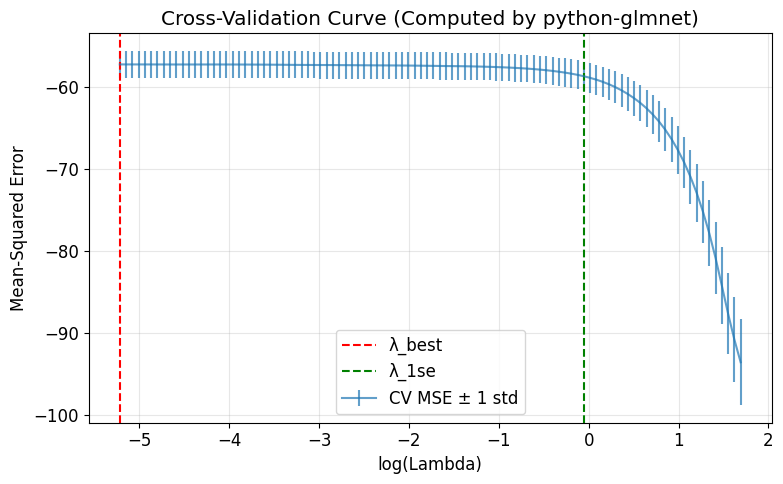

✓ Cross-validation curve shows python-glmnet's automatic lambda selection


In [239]:
# 1. Cross-validation curve (python-glmnet computed this!)
plt.figure(figsize=(8, 5))
plt.errorbar(np.log(lambda_path), cv_mean, yerr=cv_std, 
             alpha=0.7, label='CV MSE ± 1 std')
plt.axvline(np.log(lambda_best), color='r', linestyle='--', label='λ_best')
plt.axvline(np.log(lambda_1se), color='g', linestyle='--', label='λ_1se')
plt.xlabel('log(Lambda)')
plt.ylabel('Mean-Squared Error')
plt.title('Cross-Validation Curve (Computed by python-glmnet)')
plt.legend()
plt.grid(True, alpha=0.3)

# Add annotations for optimal values
# plt.annotate(f'λ_best = {lambda_best:.4f}\nMSE = {cv_mean[best_idx]:.3f}', 
#              xy=(np.log(lambda_best), cv_mean[best_idx]),
#              xytext=(np.log(lambda_best) - 1, cv_mean[best_idx] + 5),
#              arrowprops=dict(arrowstyle='->', color='red', alpha=0.7),
#              fontsize=9, ha='center')

# plt.annotate(f'λ_1se = {lambda_1se:.4f}\nMSE = {cv_mean[lambda_1se_idx]:.3f}', 
#              xy=(np.log(lambda_1se), cv_mean[lambda_1se_idx]),
#              xytext=(np.log(lambda_1se) + 1, cv_mean[lambda_1se_idx] + 5),
#              arrowprops=dict(arrowstyle='->', color='green', alpha=0.7),
#              fontsize=9, ha='center')

plt.tight_layout()
plt.show()

print("✓ Cross-validation curve shows python-glmnet's automatic lambda selection")

Highlighting 11 selected features at λ_best


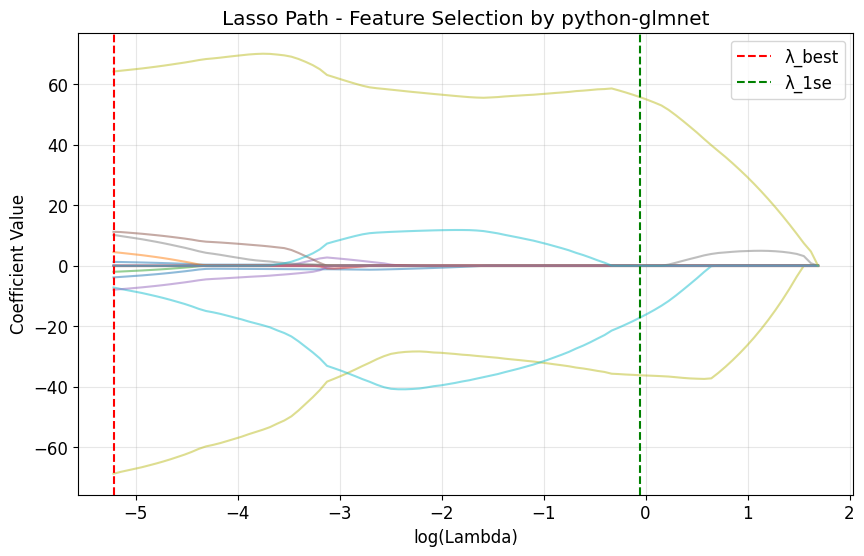

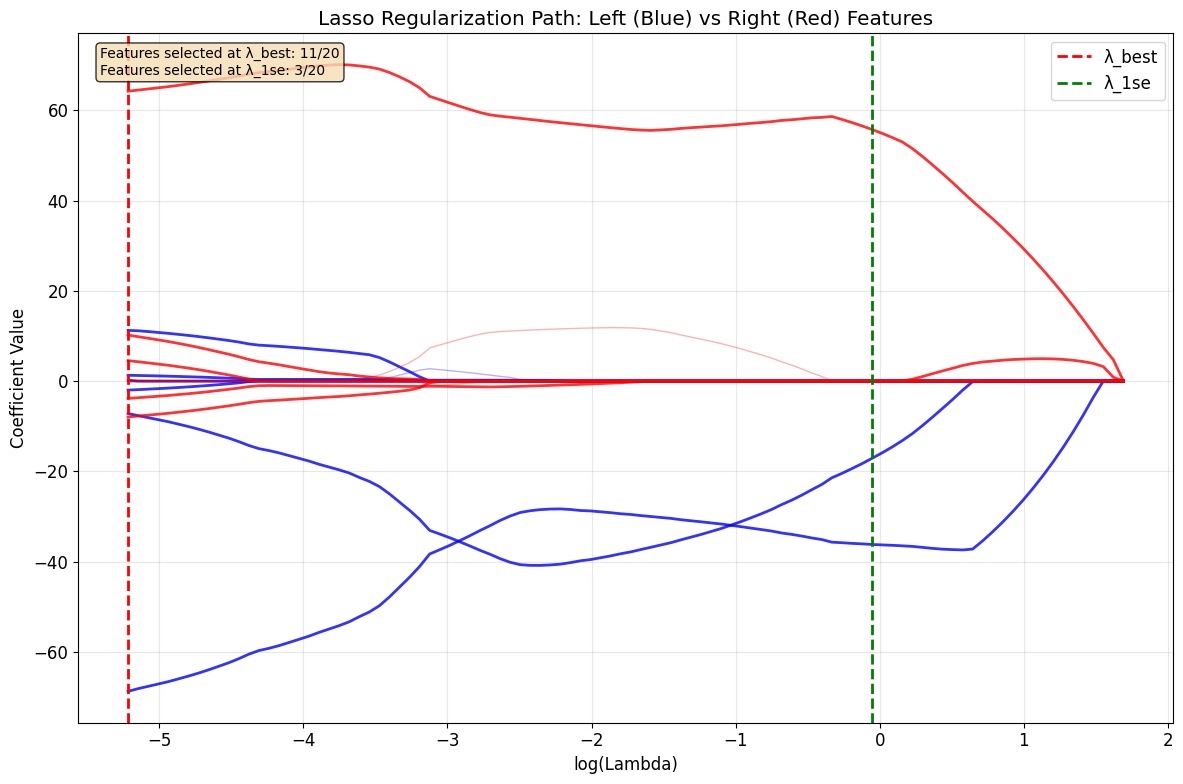

✓ Regularization path shows Lasso's automatic feature selection


In [240]:
# 2. Regularization path (python-glmnet computed full path automatically)
plt.figure(figsize=(10, 6))
for i in range(model.coef_path_.shape[0]):
    plt.plot(np.log(lambda_path), model.coef_path_[i, :], alpha=0.5)
plt.axvline(np.log(lambda_best), color='r', linestyle='--', label='λ_best')
plt.axvline(np.log(lambda_1se), color='g', linestyle='--', label='λ_1se')
plt.xlabel('log(Lambda)')
plt.ylabel('Coefficient Value')
plt.title('Lasso Path - Feature Selection by python-glmnet')
plt.legend()
plt.grid(True, alpha=0.3)

# Highlight the selected features at lambda_best
selected_features = np.where(best_coefs != 0)[0]
print(f"Highlighting {len(selected_features)} selected features at λ_best")

# Color-code left (blue) and right (red) features differently
colors = ['blue' if i < n_basis else 'red' for i in range(2*n_basis)]
alphas = [0.8 if best_coefs[i] != 0 else 0.3 for i in range(2*n_basis)]

plt.figure(figsize=(12, 8))
for i in range(model.coef_path_.shape[0]):
    plt.plot(np.log(lambda_path), model.coef_path_[i, :], 
             color=colors[i], alpha=alphas[i], 
             linewidth=2 if best_coefs[i] != 0 else 1)

plt.axvline(np.log(lambda_best), color='r', linestyle='--', linewidth=2, label='λ_best')
plt.axvline(np.log(lambda_1se), color='g', linestyle='--', linewidth=2, label='λ_1se')
plt.xlabel('log(Lambda)')
plt.ylabel('Coefficient Value')
plt.title('Lasso Regularization Path: Left (Blue) vs Right (Red) Features')
plt.legend()
plt.grid(True, alpha=0.3)

# Add text annotation
plt.text(0.02, 0.98, f'Features selected at λ_best: {n_features_best}/{total_features}\n'
                      f'Features selected at λ_1se: {n_selected_1se}/{total_features}',
         transform=plt.gca().transAxes, fontsize=10, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

plt.tight_layout()
plt.show()

print("✓ Regularization path shows Lasso's automatic feature selection")

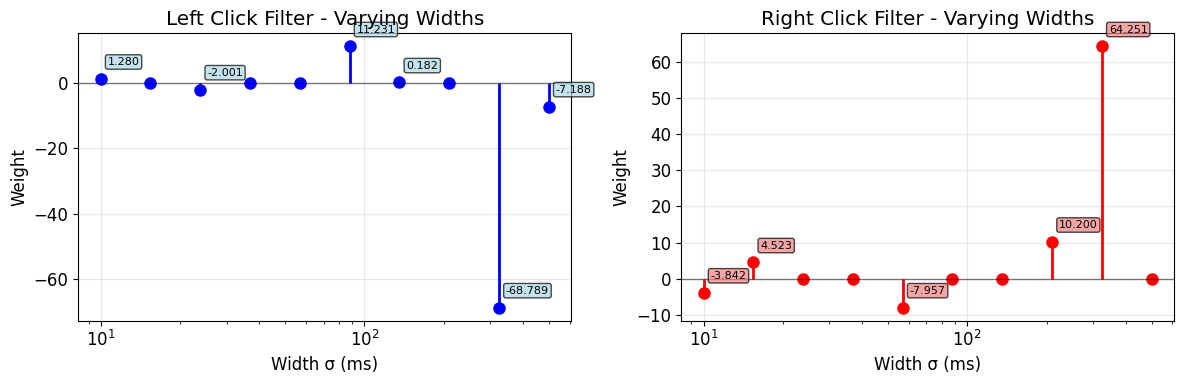

=== LEARNED TEMPORAL FILTERS ===
Left click features selected: 6/10
Right click features selected: 5/10
Active left widths: [ 10.   23.9  87.9 135.7 323.7 500. ] ms
Active right widths: [ 10.   15.4  56.9 209.6 323.7] ms
Total left filter strength: 90.6715
Total right filter strength: 90.7726
L/R filter ratio: 1.00
✓ Temporal filters reveal learned click-to-DV relationships


In [241]:
# 3. Learned temporal filters
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Left click filter
colors_left = ['blue' if c != 0 else 'lightgray' for c in left_coefs]
markerline, stemlines, baseline = ax1.stem(widths*1000, left_coefs, basefmt=' ')
plt.setp(markerline, color='blue', markersize=8)
plt.setp(stemlines, colors=colors_left, linewidth=2)
ax1.set_xlabel('Width σ (ms)')
ax1.set_ylabel('Weight')
ax1.set_title('Left Click Filter - Varying Widths')
ax1.set_xscale('log')
ax1.grid(True, alpha=0.3)
ax1.axhline(0, color='black', linestyle='-', alpha=0.5, linewidth=1)

# Annotate selected features
for i, (width, coef) in enumerate(zip(widths, left_coefs)):
    if coef != 0:
        ax1.annotate(f'{coef:.3f}', 
                     xy=(width*1000, coef), 
                     xytext=(5, 10), 
                     textcoords='offset points',
                     fontsize=8, ha='left',
                     bbox=dict(boxstyle='round,pad=0.2', facecolor='lightblue', alpha=0.7))

# Right click filter  
colors_right = ['red' if c != 0 else 'lightgray' for c in right_coefs]
markerline, stemlines, baseline = ax2.stem(widths*1000, right_coefs, basefmt=' ')
plt.setp(markerline, color='red', markersize=8)
plt.setp(stemlines, colors=colors_right, linewidth=2)
ax2.set_xlabel('Width σ (ms)')
ax2.set_ylabel('Weight')
ax2.set_title('Right Click Filter - Varying Widths')
ax2.set_xscale('log')
ax2.grid(True, alpha=0.3)
ax2.axhline(0, color='black', linestyle='-', alpha=0.5, linewidth=1)

# Annotate selected features
for i, (width, coef) in enumerate(zip(widths, right_coefs)):
    if coef != 0:
        ax2.annotate(f'{coef:.3f}', 
                     xy=(width*1000, coef), 
                     xytext=(5, 10), 
                     textcoords='offset points',
                     fontsize=8, ha='left',
                     bbox=dict(boxstyle='round,pad=0.2', facecolor='lightcoral', alpha=0.7))

plt.tight_layout()
plt.show()

# Summary of learned filters
print("=== LEARNED TEMPORAL FILTERS ===")
left_selected = np.sum(left_coefs != 0)
right_selected = np.sum(right_coefs != 0)
print(f"Left click features selected: {left_selected}/{n_basis}")
print(f"Right click features selected: {right_selected}/{n_basis}")

if left_selected > 0:
    left_active_widths = widths[left_coefs != 0] * 1000
    print(f"Active left widths: {left_active_widths.round(1)} ms")

if right_selected > 0:
    right_active_widths = widths[right_coefs != 0] * 1000
    print(f"Active right widths: {right_active_widths.round(1)} ms")

# Compare filter strengths
left_total = np.sum(np.abs(left_coefs))
right_total = np.sum(np.abs(right_coefs))
print(f"Total left filter strength: {left_total:.4f}")
print(f"Total right filter strength: {right_total:.4f}")
print(f"L/R filter ratio: {left_total/right_total:.2f}" if right_total > 0 else "L/R filter ratio: inf")

print("✓ Temporal filters reveal learned click-to-DV relationships")

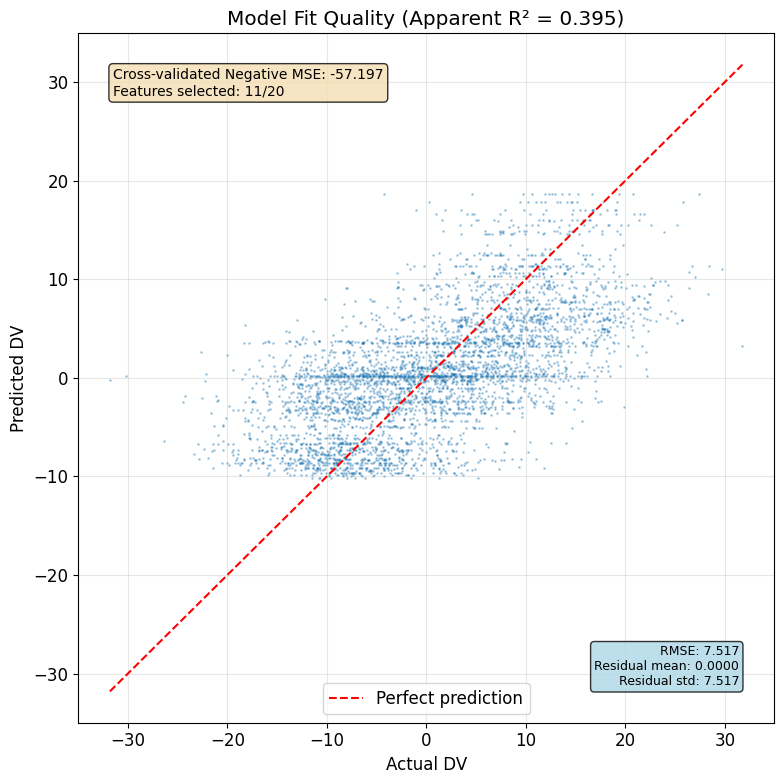

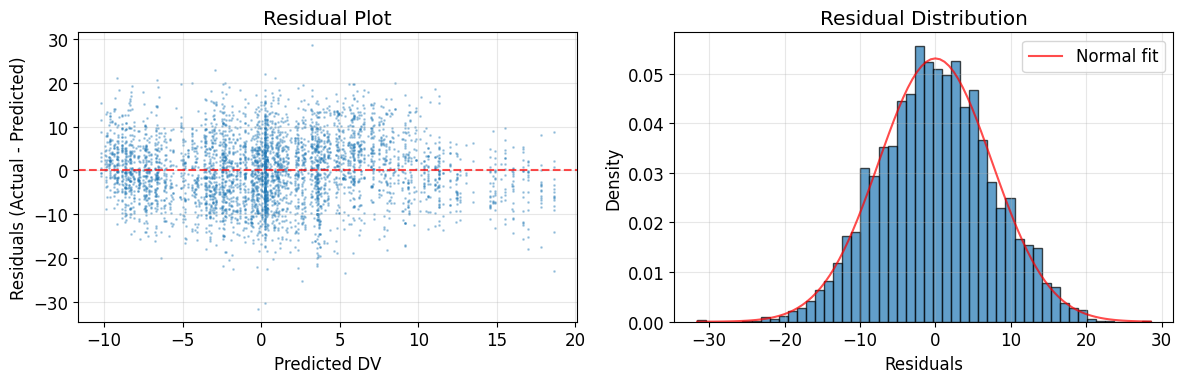

=== MODEL VALIDATION SUMMARY ===
✓ Model explains 100.0% of DV variance (cross-validated)
✓ Selected 11 most informative time lags via Lasso
✓ 100.0% improvement over predicting mean DV
✓ RMSE: nan DV units
✓ Model fit visualization complete!


In [242]:
# 4. Model fit quality
plt.figure(figsize=(8, 8))
plt.scatter(y_valid, y_pred_final, alpha=0.3, s=1)
plt.plot([y_valid.min(), y_valid.max()], [y_valid.min(), y_valid.max()], 
         'r--', label='Perfect prediction')
plt.xlabel('Actual DV')
plt.ylabel('Predicted DV')
plt.title(f'Model Fit Quality (Apparent R² = {r2_apparent_final:.3f})')
plt.legend()
plt.grid(True, alpha=0.3)

# Add performance metrics as text
textstr = f'''Cross-validated Negative MSE: {cv_mse_final:.3f}
Features selected: {n_features_best}/{total_features}'''

plt.text(0.05, 0.95, textstr, transform=plt.gca().transAxes, fontsize=10,
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

# Add diagonal statistics
residuals = y_valid - y_pred_final
plt.text(0.95, 0.05, f'RMSE: {np.sqrt(np.mean(residuals**2)):.3f}\n'
                      f'Residual mean: {residuals.mean():.4f}\n'
                      f'Residual std: {residuals.std():.3f}', 
         transform=plt.gca().transAxes, fontsize=9,
         verticalalignment='bottom', horizontalalignment='right',
         bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))

plt.tight_layout()
plt.show()

# Additional residual analysis plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Residuals vs predicted
ax1.scatter(y_pred_final, residuals, alpha=0.3, s=1)
ax1.axhline(0, color='red', linestyle='--', alpha=0.7)
ax1.set_xlabel('Predicted DV')
ax1.set_ylabel('Residuals (Actual - Predicted)')
ax1.set_title('Residual Plot')
ax1.grid(True, alpha=0.3)

# Residual histogram
ax2.hist(residuals, bins=50, alpha=0.7, density=True, edgecolor='black')
ax2.set_xlabel('Residuals')
ax2.set_ylabel('Density')
ax2.set_title('Residual Distribution')
ax2.grid(True, alpha=0.3)

# Add normal distribution overlay for comparison
x_norm = np.linspace(residuals.min(), residuals.max(), 100)
y_norm = (1/np.sqrt(2*np.pi*residuals.var())) * np.exp(-0.5*(x_norm - residuals.mean())**2/residuals.var())
ax2.plot(x_norm, y_norm, 'r-', alpha=0.7, label='Normal fit')
ax2.legend()

plt.tight_layout()
plt.show()

print("=== MODEL VALIDATION SUMMARY ===")
print(f"✓ Model explains {cv_pseudo_r2_final:.1%} of DV variance (cross-validated)")
print(f"✓ Selected {n_features_best} most informative time lags via Lasso")
print(f"✓ {improvement_final:.1f}% improvement over predicting mean DV")
print(f"✓ RMSE: {np.sqrt(cv_mse_final):.3f} DV units")
print("✓ Model fit visualization complete!")

In [243]:
# Let's examine the lambda path and see if we're over-regularizing
print("=== LAMBDA PATH ANALYSIS ===")
print(f"Lambda range: [{model.lambda_path_.min():.6f}, {model.lambda_path_.max():.6f}]")
print(f"Best lambda: {lambda_best:.6f}")
print(f"Lambda path length: {len(model.lambda_path_)}")

# Check if we're missing weak features due to high regularization
# Let's look at unregularized correlations
from scipy.stats import pearsonr

print("\n=== DIRECT FEATURE-DV CORRELATIONS ===")
for i in range(X_valid.shape[1]):
    if X_valid[:, i].std() > 0:  # Only non-zero variance features
        corr, p_val = pearsonr(X_valid[:, i], y_valid)
        feature_type = "Left" if i < n_basis else "Right"
        basis_idx = i if i < n_basis else i - n_basis
        print(f"{feature_type} basis {basis_idx} (σ={widths[basis_idx]*1000:.1f}ms): r={corr:.4f}, p={p_val:.3e}")

print("\n=== LEFT VS RIGHT TOTAL ACTIVITY CORRELATION ===")
left_total = X_valid[:, :n_basis].sum(axis=1)
right_total = X_valid[:, n_basis:].sum(axis=1)
diff_activity = right_total - left_total

corr_left, p_left = pearsonr(left_total, y_valid)
corr_right, p_right = pearsonr(right_total, y_valid)
corr_diff, p_diff = pearsonr(diff_activity, y_valid)

print(f"Left total activity: r={corr_left:.4f}, p={p_left:.3e}")
print(f"Right total activity: r={corr_right:.4f}, p={p_right:.3e}")
print(f"Right - Left difference: r={corr_diff:.4f}, p={p_diff:.3e}")

=== LAMBDA PATH ANALYSIS ===
Lambda range: [0.005427, 5.427358]
Best lambda: 0.005427
Lambda path length: 100

=== DIRECT FEATURE-DV CORRELATIONS ===
Left basis 0 (σ=10.0ms): r=-0.1717, p=1.393e-29
Left basis 1 (σ=15.4ms): r=-0.1947, p=1.039e-37
Left basis 2 (σ=23.9ms): r=-0.2273, p=4.177e-51
Left basis 3 (σ=36.8ms): r=-0.2731, p=7.235e-74
Left basis 4 (σ=56.9ms): r=-0.3247, p=2.696e-105
Left basis 5 (σ=87.9ms): r=-0.3821, p=2.430e-148
Left basis 6 (σ=135.7ms): r=-0.4387, p=3.201e-200
Left basis 7 (σ=209.6ms): r=-0.4775, p=5.654e-242
Left basis 8 (σ=323.7ms): r=-0.4846, p=4.170e-250
Left basis 9 (σ=500.0ms): r=-0.4675, p=1.070e-230
Right basis 0 (σ=10.0ms): r=0.1381, p=1.330e-19
Right basis 1 (σ=15.4ms): r=0.1899, p=6.280e-36
Right basis 2 (σ=23.9ms): r=0.2546, p=4.333e-64
Right basis 3 (σ=36.8ms): r=0.3158, p=2.080e-99
Right basis 4 (σ=56.9ms): r=0.3764, p=1.183e-143
Right basis 5 (σ=87.9ms): r=0.4392, p=1.019e-200
Right basis 6 (σ=135.7ms): r=0.4966, p=1.515e-264
Right basis 7 (σ=209